In [1]:
USE_KDE = True
if USE_KDE:
    import adaptivekde as kde

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import scipy.special as sc
import scipy.stats as ss
import symengine as syme
import sympy as sym
import sympy.stats as syms
import sympy.stats.rv as rv

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 3.0)
plt.rcParams['figure.dpi'] = 500

In [5]:
def S_N_lts(s, N, U, tilt=0):
    p_0 = syms.P(N < 1)
    
    x = sym.Dummy('x')
    U_laplace = sym.integrate(sym.exp(-s*x)*syms.density(U)(x), 
                             (x, 0, sym.oo), conds='none')
    
    N_PGF = syms.E(s**N)
    factors = [arg if not arg.is_Piecewise else arg.args[0][0] for arg in N_PGF.args]
    N_PGF = sym.Mul(*factors)
    
    S_N_laplace = N_PGF.subs(s, U_laplace)
    S_N_plus_laplace = (S_N_laplace.subs(s, s+tilt)-p_0).simplify()
    return(S_N_laplace, S_N_plus_laplace)    

In [6]:
def Qcal(z, S_N_plus_laplace, ref_r, ref_m):
    s = S_N_plus_laplace.free_symbols.pop()
    return((1+z)**(-ref_r) * S_N_plus_laplace.subs(s, -z / ((z+1)*ref_m)))

In [7]:
def q_coefficients(S_N_plus_laplace, ref_r, ref_m, K, fast=True):
    x = sym.Dummy('x')
    Qx = Qcal(x, S_N_plus_laplace, ref_r, ref_m)
    if fast:
        taylor = syme.series(Qx, x, n=K+1)
    else:
        taylor = sym.series(Qx, x, n=K+1)
    coeffs = [taylor.subs({x: 0})]
    coeffs += [taylor.coeff(x, i) for i in range(1, K+1)]
    
    ks = np.arange(K+1)
    cs = np.sqrt(sc.gamma(ks + float(ref_r)) / (sc.gamma(ks+1) * sc.gamma(float(ref_r))))
    return(coeffs / cs)

In [8]:
def p_from_q(qs, ref_r, ref_m, tilt=0, fast=True):
    K = len(qs)-1
    ps = []
    for i in range(K+1):
        ks = np.arange(i,K+1)
        firstTerms = qs[ks]
        secondTerms = (-1)**(i+ks) / (sc.factorial(i) * sc.factorial(ks-i))
        thirdTerms = np.sqrt(sc.factorial(ks) * sc.gamma(ks+float(ref_r)) / sc.gamma(float(ref_r)))
        newP = np.sum(firstTerms * secondTerms * thirdTerms)
        if not fast:
            newP = sym.re(newP.n().subs(sym.exp_polar, sym.exp))
        ps.append(float(newP) / (1 - float(ref_m)*tilt)**(float(ref_r)+i))
    
    return(np.array(ps))

In [9]:
def rcompsum(R, NDist, UDist):
    rvs = np.zeros(R)
    Ns = NDist.rvs(R)
    numToGo = Ns.sum()
    maxBatch = int(1e7)
    
    i = 0
    summands = []
    
    for r in range(R):
        # Simulate a new batch of summands if we've used up
        # the last batch.
        if i+Ns[r] >= len(summands):
            summands = summands[i:]
            batch = np.minimum(maxBatch, numToGo)
            numToGo -= batch
            summands = np.concatenate([summands, UDist.rvs(batch)])
            i = 0
            
        rvs[r] = np.sum(summands[i:i+Ns[r]])
        i += Ns[r]

    return(rvs)

In [10]:
def dcompsum(x, ps, ref_r, ref_m):
    pdf = np.zeros(len(x))
    for i in range(len(ps)):
        pdf += ps[i] * ss.gamma(ref_r+i, scale=ref_m).pdf(x)
    return(pdf)

def pcompsum(x, ps, ref_r, ref_m):
    sfs = np.zeros(len(x))
    for i in range(len(ps)):
        sfs += ps[i] * ss.gamma(ref_r+i, scale=ref_m).sf(x)
    return(1 - sfs)

In [11]:
def laguerre_polynomial(n, r, m, xs):
    return((-1)**n * sc.binom(n+r-1, n)**(-0.5) * sc.eval_genlaguerre(n, r-1, xs/m))

def q_coefficients_empirically(rvs, K, r, m):
    qs = np.empty(K+1)
    qs[0] = 1
    for k in range(1, K+1):
        qs[k] = np.mean(laguerre_polynomial(k, r, m, rvs))
    return(qs)

def laguerre_expansion(qs, xs, r, m):
    K = len(qs)-1
    pdfs = np.zeros(len(xs))
    
    for k in range(0, K+1):
        pdfs += qs[k] * laguerre_polynomial(k, r, m, xs)
    
    pdfs *= ss.gamma(r, scale=m).pdf(xs)
    
    return(pdfs)

In [12]:
def transform_inversion(lt, x, a=18.5, M1=10, M2=10):
    k = np.arange(M1+M2+1)
    #Ss = np.exp(a/2) / x * (-1)**k * lt((a + 2*np.pi*k*1j)/(2*x)).real
    vec = np.array([lt((a + 2*np.pi*kk*1j)/(2*x)) for kk in k])
    Ss = np.exp(a/2) / x * (-1)**k * vec
    Ss[0] /= 2
    Ss = np.cumsum(Ss)
    
    k = np.arange(M1+1)
    return(np.sum(sc.binom(M1, k) * 2**(-M1) * Ss[M2+k]))

In [13]:
def laplace_inversion_method(NDist, UDist, S_N_plus_laplace):
    U_laplace = np.vectorize(lambda s: UDist.expect(lambda x: np.exp(-s*x)))

## Test 0: Negative Binomial / Exponential

In [14]:
N_alpha = 10
N_p = sym.QQ(3, 4)
U_r = 1
U_m = sym.QQ(1, 6)

N = syms.NegativeBinomial('N', N_alpha, 1-N_p) 
U = syms.Gamma('U', U_r, U_m)

# Set K, r & m of the reference distribution using
# the result from Lemma 2 in the paper.
K = N_alpha - 1
ref_r = 1
ref_m = U_m / N_p

s = sym.symbols('s')
#S_N_plus_laplace = S_N_plus_laplace_sym(s, N, U)
S_N_laplace, S_N_plus_laplace = S_N_lts(s, N, U)
S_N_plus_laplace

59049*(s + 6)**10/(1024*(2*s + 9)**10) - 59049/1048576

In [15]:
%%time
qs = q_coefficients(S_N_plus_laplace, ref_r, ref_m, K)
qsFloat = [float(q.n()) for q in qs]
print(qsFloat)

[0.9436864852905273, 1.5563135147094727, 1.2561864852905273, 0.6188135147094727, 0.20149898529052734, 0.044594764709472656, 0.006674766540527344, 0.0006494522094726562, 3.719329833984375e-05, 9.5367431640625e-07]
Wall time: 39.9 ms


In [16]:
ps = p_from_q(qs, ref_r, ref_m)
print(ps)

[1.87711716e-01 2.81567574e-01 2.50282288e-01 1.45998001e-01
 5.83992004e-02 1.62220001e-02 3.08990479e-03 3.86238098e-04
 2.86102295e-05 9.53674316e-07]


In [17]:
pdfLT = sym.lambdify(s, S_N_laplace)
cdfLT = sym.lambdify(s, S_N_laplace/s)
svfLT = sym.lambdify(s, (1-S_N_laplace)/s)

pdfInv = np.vectorize(lambda x: transform_inversion(pdfLT, x))
cdfInv = np.vectorize(lambda x: transform_inversion(cdfLT, x))
svfInv = np.vectorize(lambda x: transform_inversion(svfLT, x))

LTStar = (1-S_N_laplace)/(s*syms.E(N)*syms.E(U))
cdfLTStar = sym.lambdify(s, LTStar / s)
svfLTStar = sym.lambdify(s, (1-LTStar) / s)

cdfStarInv = np.vectorize(lambda x: transform_inversion(cdfLTStar, x))
svfStarInv = np.vectorize(lambda x: transform_inversion(svfLTStar, x))

In [18]:
%%time 
rnd.seed(1)
R = int(1e6)

NDist = ss.nbinom(N_alpha, float(N_p))
UDist = ss.gamma(float(U_r), scale=float(U_m))

rvs = rcompsum(R, NDist, UDist)

Wall time: 8.49 s


In [19]:
[syms.E(N).n(), NDist.mean(), (syms.E(N**2)-syms.E(N)**2).n(), NDist.var()]

[3.33333333333333, 3.3333333333333326, 4.44444444444444, 4.444444444444443]

In [20]:
[syms.E(U).n(), UDist.mean(), (syms.E(U**2)-syms.E(U)**2).n(), UDist.var()]

[0.166666666666667,
 0.16666666666666666,
 0.0277777777777778,
 0.027777777777777776]

In [21]:
posRVs = np.array([x for x in rvs if x > 0])
p_0 = (R - len(posRVs)) / R

In [22]:
xMax = np.max(rvs) / 2
xs = np.linspace(-2, xMax, 500)
xsPos = xs[xs > 0]

ref_r = float(ref_r)
ref_m = float(ref_m)

pdfsInv = pdfInv(xsPos)
pdfsPoly = dcompsum(xsPos, ps, ref_r, ref_m)

qsEmp = (1-p_0) * q_coefficients_empirically(posRVs, K, ref_r, ref_m)

pdfsLag = laguerre_expansion(qsFloat, xsPos, ref_r, ref_m)
pdfsLagEmp = laguerre_expansion(qsEmp, xsPos, ref_r, ref_m)

In [23]:
if USE_KDE:
    pdfsKDEAll = kde.ssvkernel(posRVs, xs, nbs=1)[0]
    probNeg = np.sum(pdfsKDEAll[xs <= 0] * (xs[1] - xs[0]))
    pdfsKDE = pdfsKDEAll[xs > 0] * (1 - p_0) / (1 - probNeg)
    print(f"probNeg={probNeg} scaling={(1 - p_0) / (1 - probNeg)}")

C:\Users\patri\Anaconda3\envs\slp\lib\site-packages\adaptivekde\ssvkernel.py:274: RuntimeWarning: invalid value encountered in true_divide
  K = 2 * np.sin(a * t / 2) / (a * t)


probNeg=0.01692970700479582 scaling=0.9598214967163117


C:\Users\patri\Anaconda3\envs\slp\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


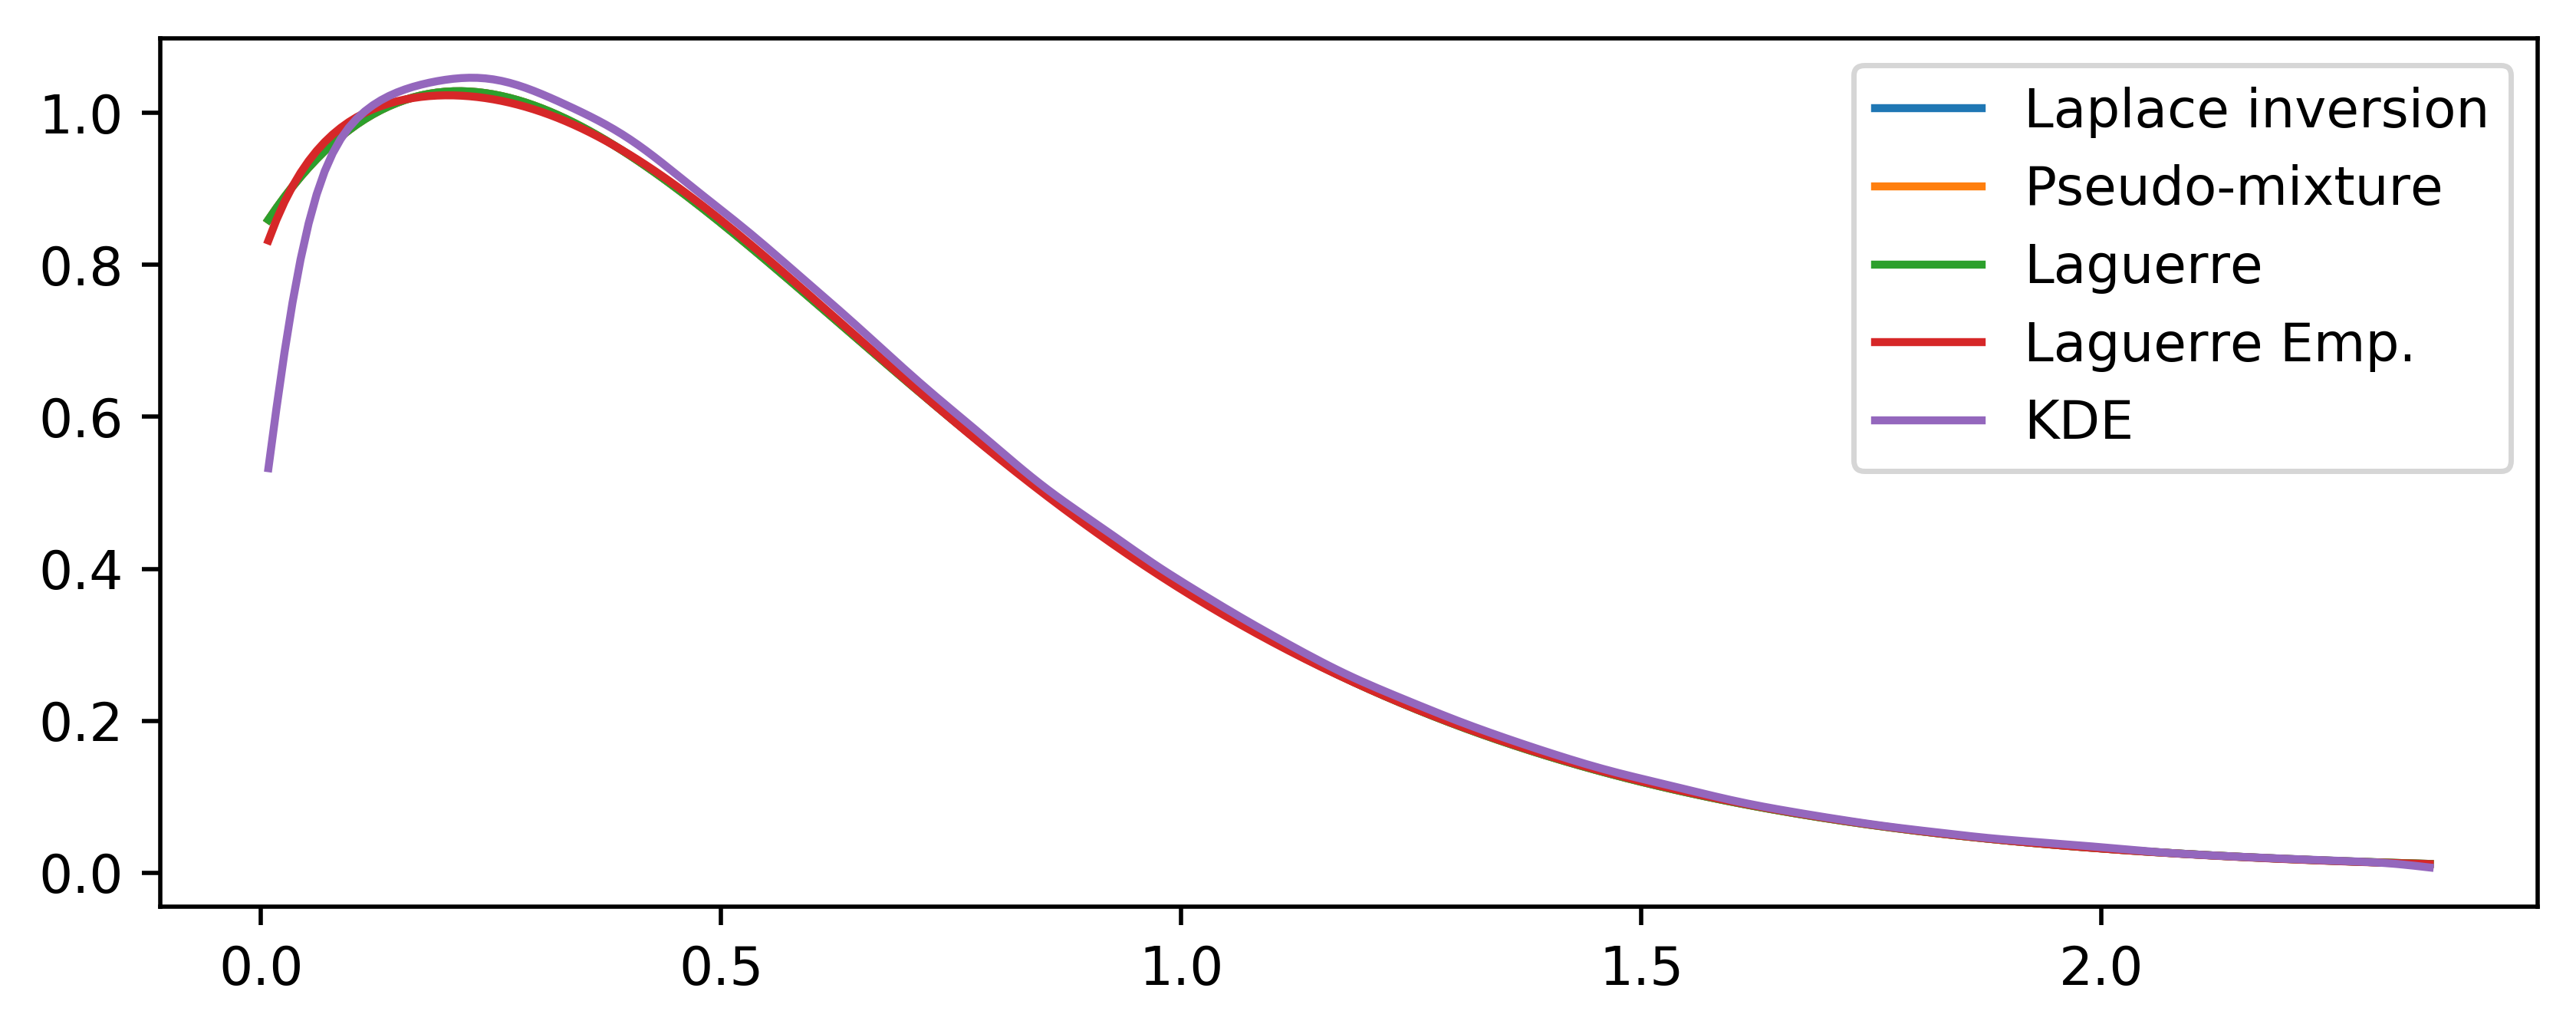

In [24]:
plt.plot(xsPos, pdfsInv, label="Laplace inversion")
plt.plot(xsPos, pdfsPoly, label="Pseudo-mixture")
plt.plot(xsPos, pdfsLag, label="Laguerre")
plt.plot(xsPos, pdfsLagEmp, label="Laguerre Emp.")
if USE_KDE:
    plt.plot(xsPos, pdfsKDE, label="KDE")
#plt.gca().set_xlim((0, xmax))
plt.legend();

In [25]:
pdfsMed = np.median(np.array([pdfsInv, pdfsPoly]), axis=0)

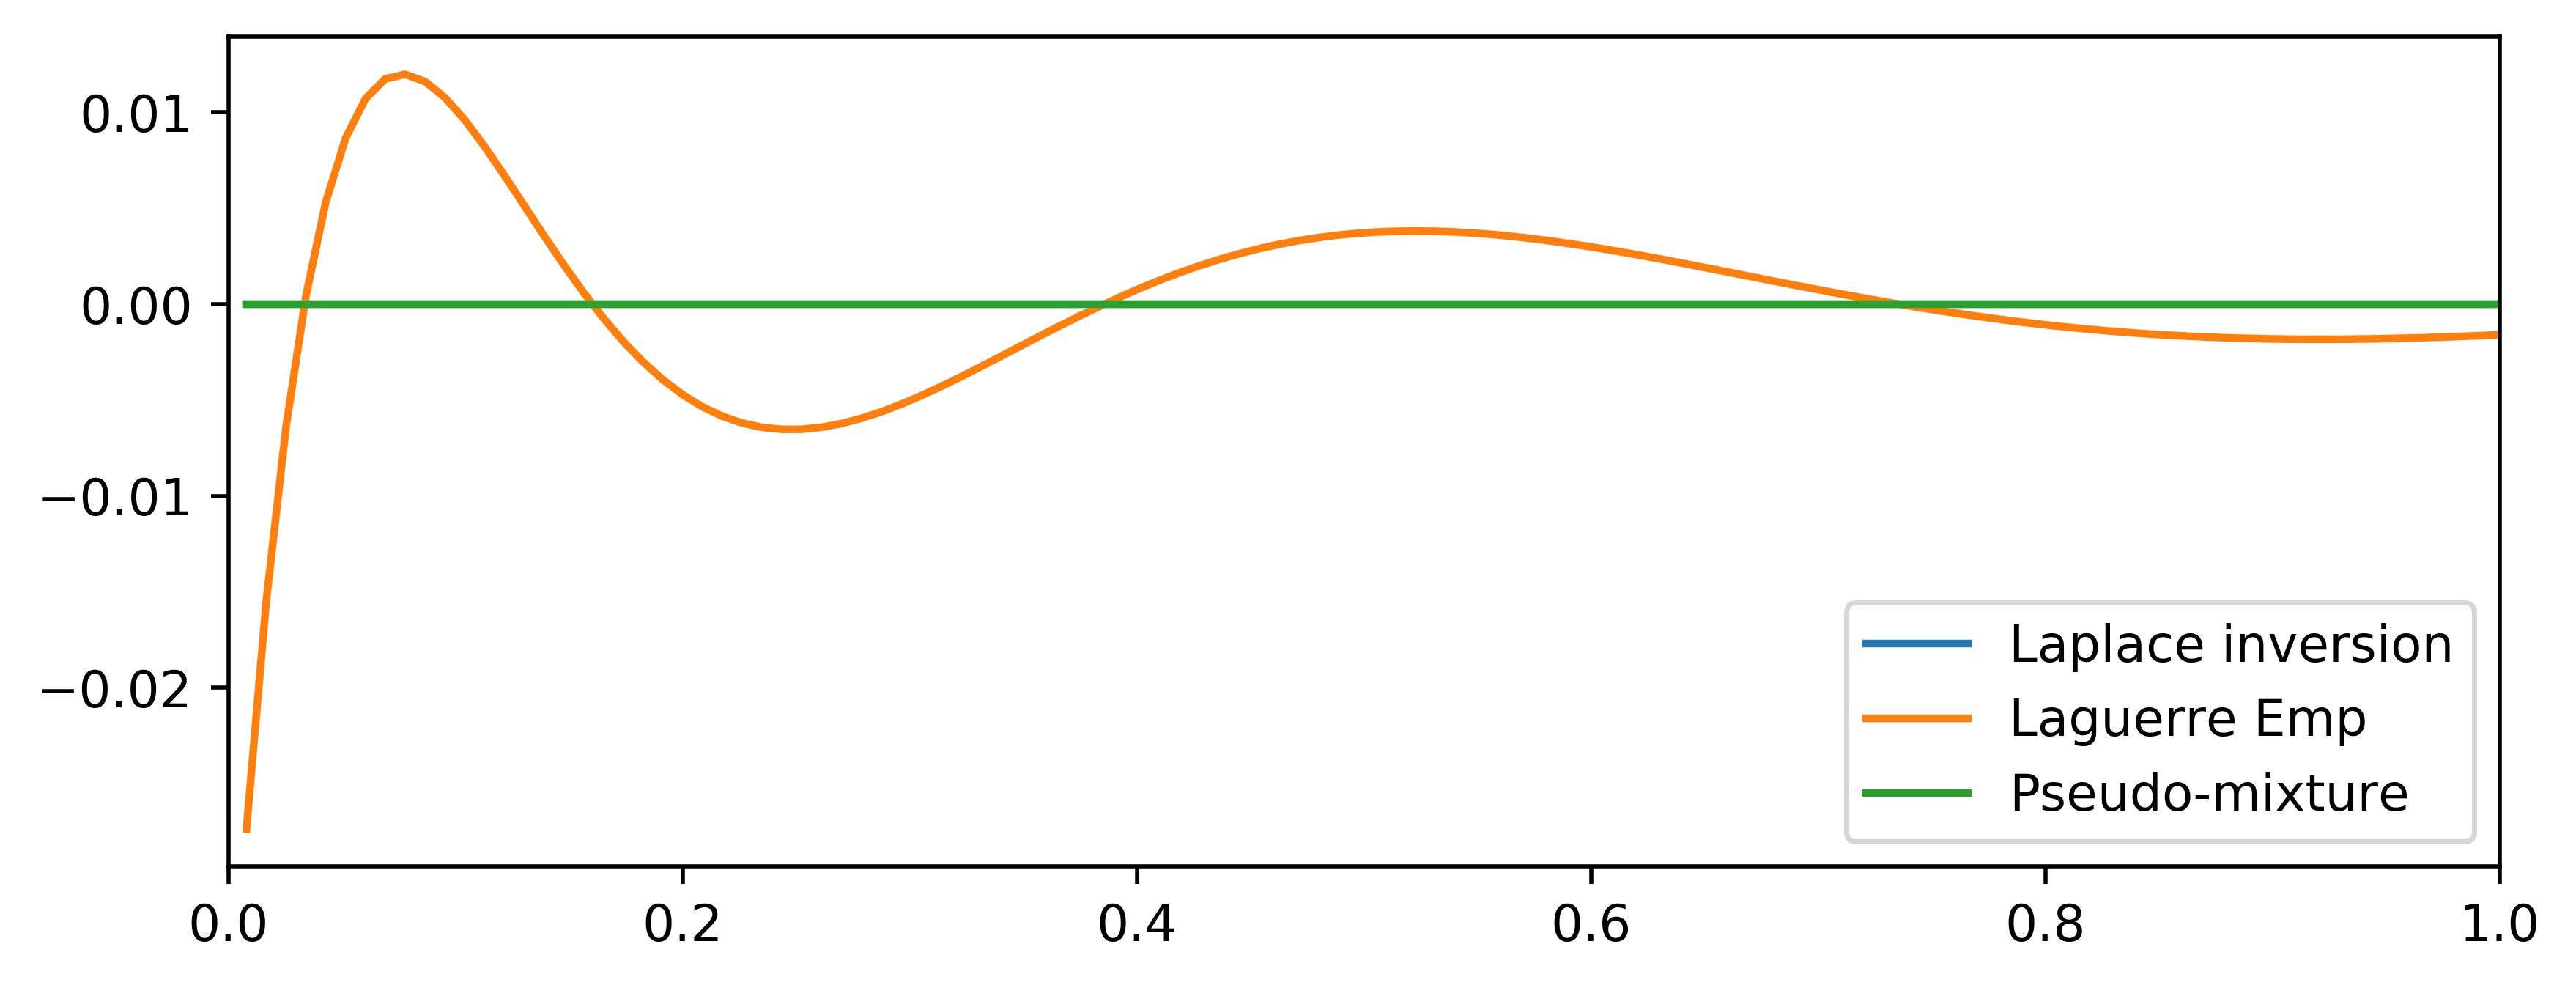

In [26]:
plt.plot(xsPos, pdfsInv-pdfsMed, label="Laplace inversion") 
# plt.plot(xsPos, pdfsLag-pdfsMed, label="Laguerre")
plt.plot(xsPos, pdfsLagEmp-pdfsMed, label="Laguerre Emp")
plt.plot(xsPos, pdfsPoly-pdfsMed, label="Pseudo-mixture")
# if USE_KDE:
#     plt.plot(xsPos, pdfsKDE-pdfsMed, label="KDE")
plt.gca().set_xlim((0, 1))
plt.legend();

In [27]:
svfsPoly = 1 - pcompsum(xsPos, ps, ref_r, ref_m)
svfsInv = svfInv(xsPos)

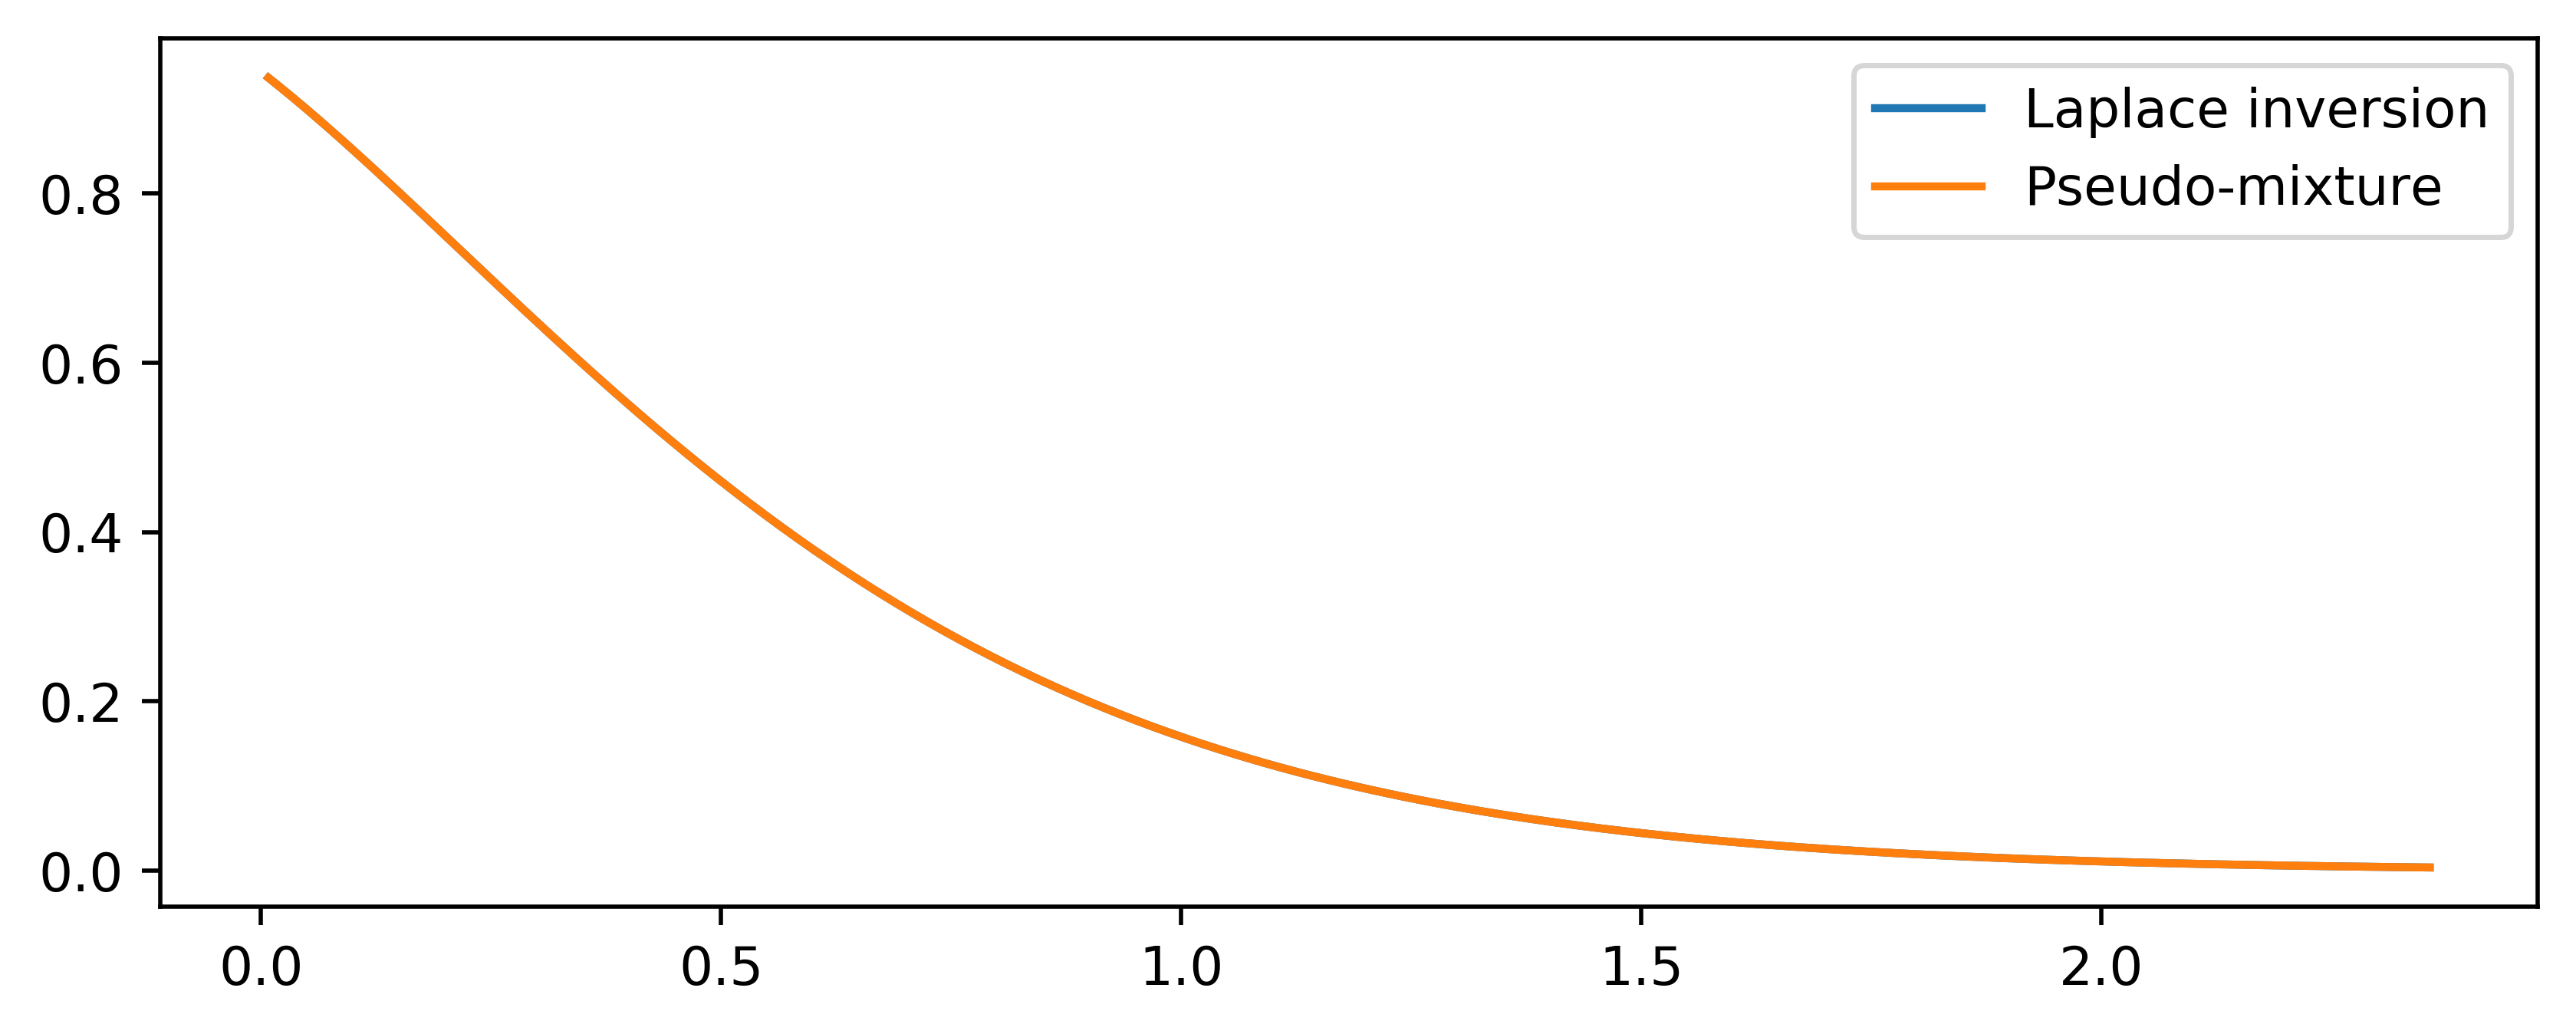

In [28]:
plt.plot(xsPos, svfsInv, label="Laplace inversion")
plt.plot(xsPos, svfsPoly, label="Pseudo-mixture")
plt.legend();

In [29]:
svfsMed = np.median(np.array([svfsPoly, svfsInv]), axis=0)

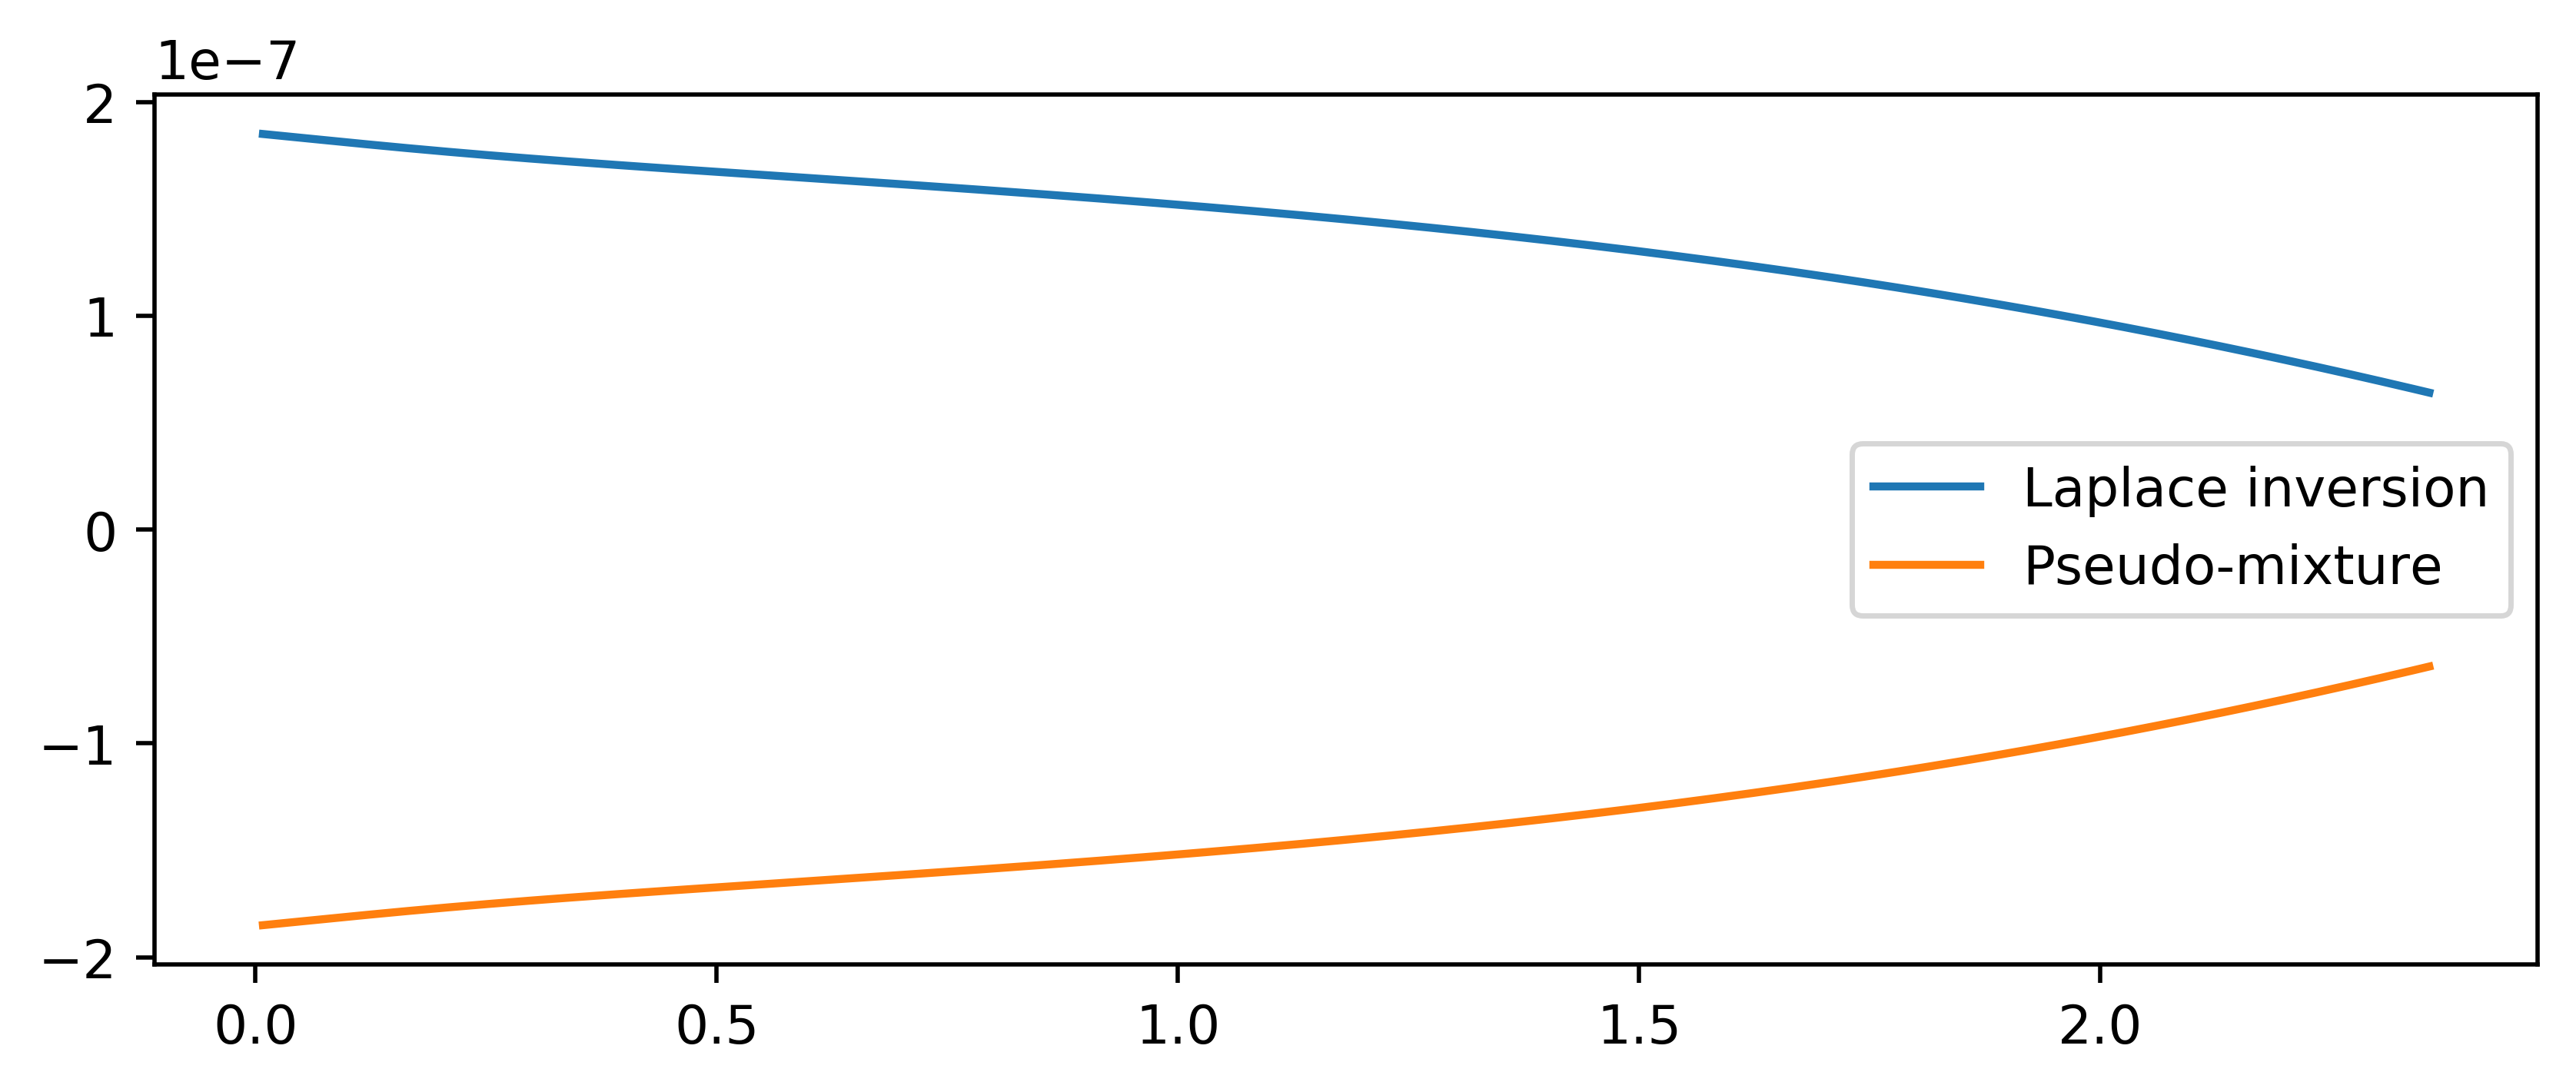

In [30]:
plt.plot(xsPos, svfsInv-svfsMed, label="Laplace inversion")
plt.plot(xsPos, svfsPoly-svfsMed, label="Pseudo-mixture")
plt.legend();

## Test 1: Poisson / Gamma.

In [31]:
N_lambda = 2
U_r = sym.QQ(3, 2)
U_m = sym.QQ(1, 3)

N = syms.Poisson('N', N_lambda)
U = syms.Gamma('U', U_r, U_m)

# Set the r & m of the reference distribution using
# the moments of N & U.
U_m1 = U_r * U_m
U_m2 = U_r * U_m**2 + U_m1**2 

ref_r = N_lambda * U_m1**2 / U_m2
ref_m = U_m2 / U_m1
K = 16

s = sym.symbols('s')
S_N_laplace, S_N_plus_laplace = S_N_lts(s, N, U)
S_N_plus_laplace

(exp(6*sqrt(3)/(s + 3)**(3/2)) - 1)*exp(-2)

In [32]:
%%time
qs = q_coefficients(S_N_plus_laplace, ref_r, ref_m, K)
qsFloat = [float(q.n(real=True)) for q in qs]
print(qsFloat)

[0.8646647167633874, 0.148252374910087, -0.1554884025679379, 0.05945775227691837, -0.011579688901637759, -0.00038479022877830547, -0.0007893602443007393, 0.00404098213884743, -0.006149149306945262, 0.006940442146655651, -0.006937718542120229, 0.0065884331364822295, -0.006140922289878872, 0.005700905755555565, -0.005300700592171459, 0.00494300285006208, -0.0046219668354922664]
Wall time: 91.8 ms


In [33]:
ps = p_from_q(qs, ref_r, ref_m)
print(ps)

[ 3.61917942e-01  1.66595485e+00 -5.32413752e+00  1.74063616e+01
 -4.44781512e+01  8.73275359e+01 -1.34751299e+02  1.65786092e+02
 -1.63609052e+02  1.29467639e+02 -8.16466385e+01  4.05149771e+01
 -1.54828077e+01  4.39932800e+00 -8.75669499e-01  1.09001862e-01
 -6.38826145e-03]


In [34]:
pdfLT = sym.lambdify(s, S_N_laplace)
cdfLT = sym.lambdify(s, S_N_laplace/s)
svfLT = sym.lambdify(s, (1-S_N_laplace)/s)

pdfInv = np.vectorize(lambda x: transform_inversion(pdfLT, x))
cdfInv = np.vectorize(lambda x: transform_inversion(cdfLT, x))
svfInv = np.vectorize(lambda x: transform_inversion(svfLT, x))

LTStar = (1-S_N_laplace)/(s*syms.E(N)*syms.E(U))
cdfLTStar = sym.lambdify(s, LTStar / s)
svfLTStar = sym.lambdify(s, (1-LTStar) / s)

cdfStarInv = np.vectorize(lambda x: transform_inversion(cdfLTStar, x))
svfStarInv = np.vectorize(lambda x: transform_inversion(svfLTStar, x))

In [35]:
%%time 
rnd.seed(1)
R = int(1e6)

NDist = ss.poisson(N_lambda)
UDist = ss.gamma(float(U_r), scale=float(U_m))

rvs = rcompsum(R, NDist, UDist)

Wall time: 9.3 s


In [36]:
[syms.E(N).n(), NDist.mean(), (syms.E(N**2)-syms.E(N)**2).n(), NDist.var()]

[2.00000000000000, 2.0, 2.00000000000000, 2.0]

In [37]:
[syms.E(U).n(), UDist.mean(), (syms.E(U**2)-syms.E(U)**2).n(), UDist.var()]

[0.500000000000000, 0.5, 0.166666666666667, 0.16666666666666666]

In [38]:
posRVs = np.array([x for x in rvs if x > 0])
p_0 = (R - len(posRVs)) / R

In [39]:
xMax = np.max(rvs) / 2
xs = np.linspace(-2, xMax, 500)
xsPos = xs[xs > 0]

ref_r = float(ref_r)
ref_m = float(ref_m)

pdfsInv = pdfInv(xsPos)
pdfsPoly = dcompsum(xsPos, ps, ref_r, ref_m)

qsEmp = (1-p_0) * q_coefficients_empirically(posRVs, K, ref_r, ref_m)

pdfsLag = laguerre_expansion(qsFloat, xsPos, ref_r, ref_m)
pdfsLagEmp = laguerre_expansion(qsEmp, xsPos, ref_r, ref_m)

In [40]:
if USE_KDE:
    pdfsKDEAll = kde.ssvkernel(posRVs, xs, nbs=1)[0]
    probNeg = np.sum(pdfsKDEAll[xs <= 0] * (xs[1] - xs[0]))
    pdfsKDE = pdfsKDEAll[xs > 0] * (1 - p_0) / (1 - probNeg)
    print(f"probNeg={probNeg} scaling={(1 - p_0) / (1 - probNeg)}")

probNeg=0.007230062634230686 scaling=0.8707445375448636


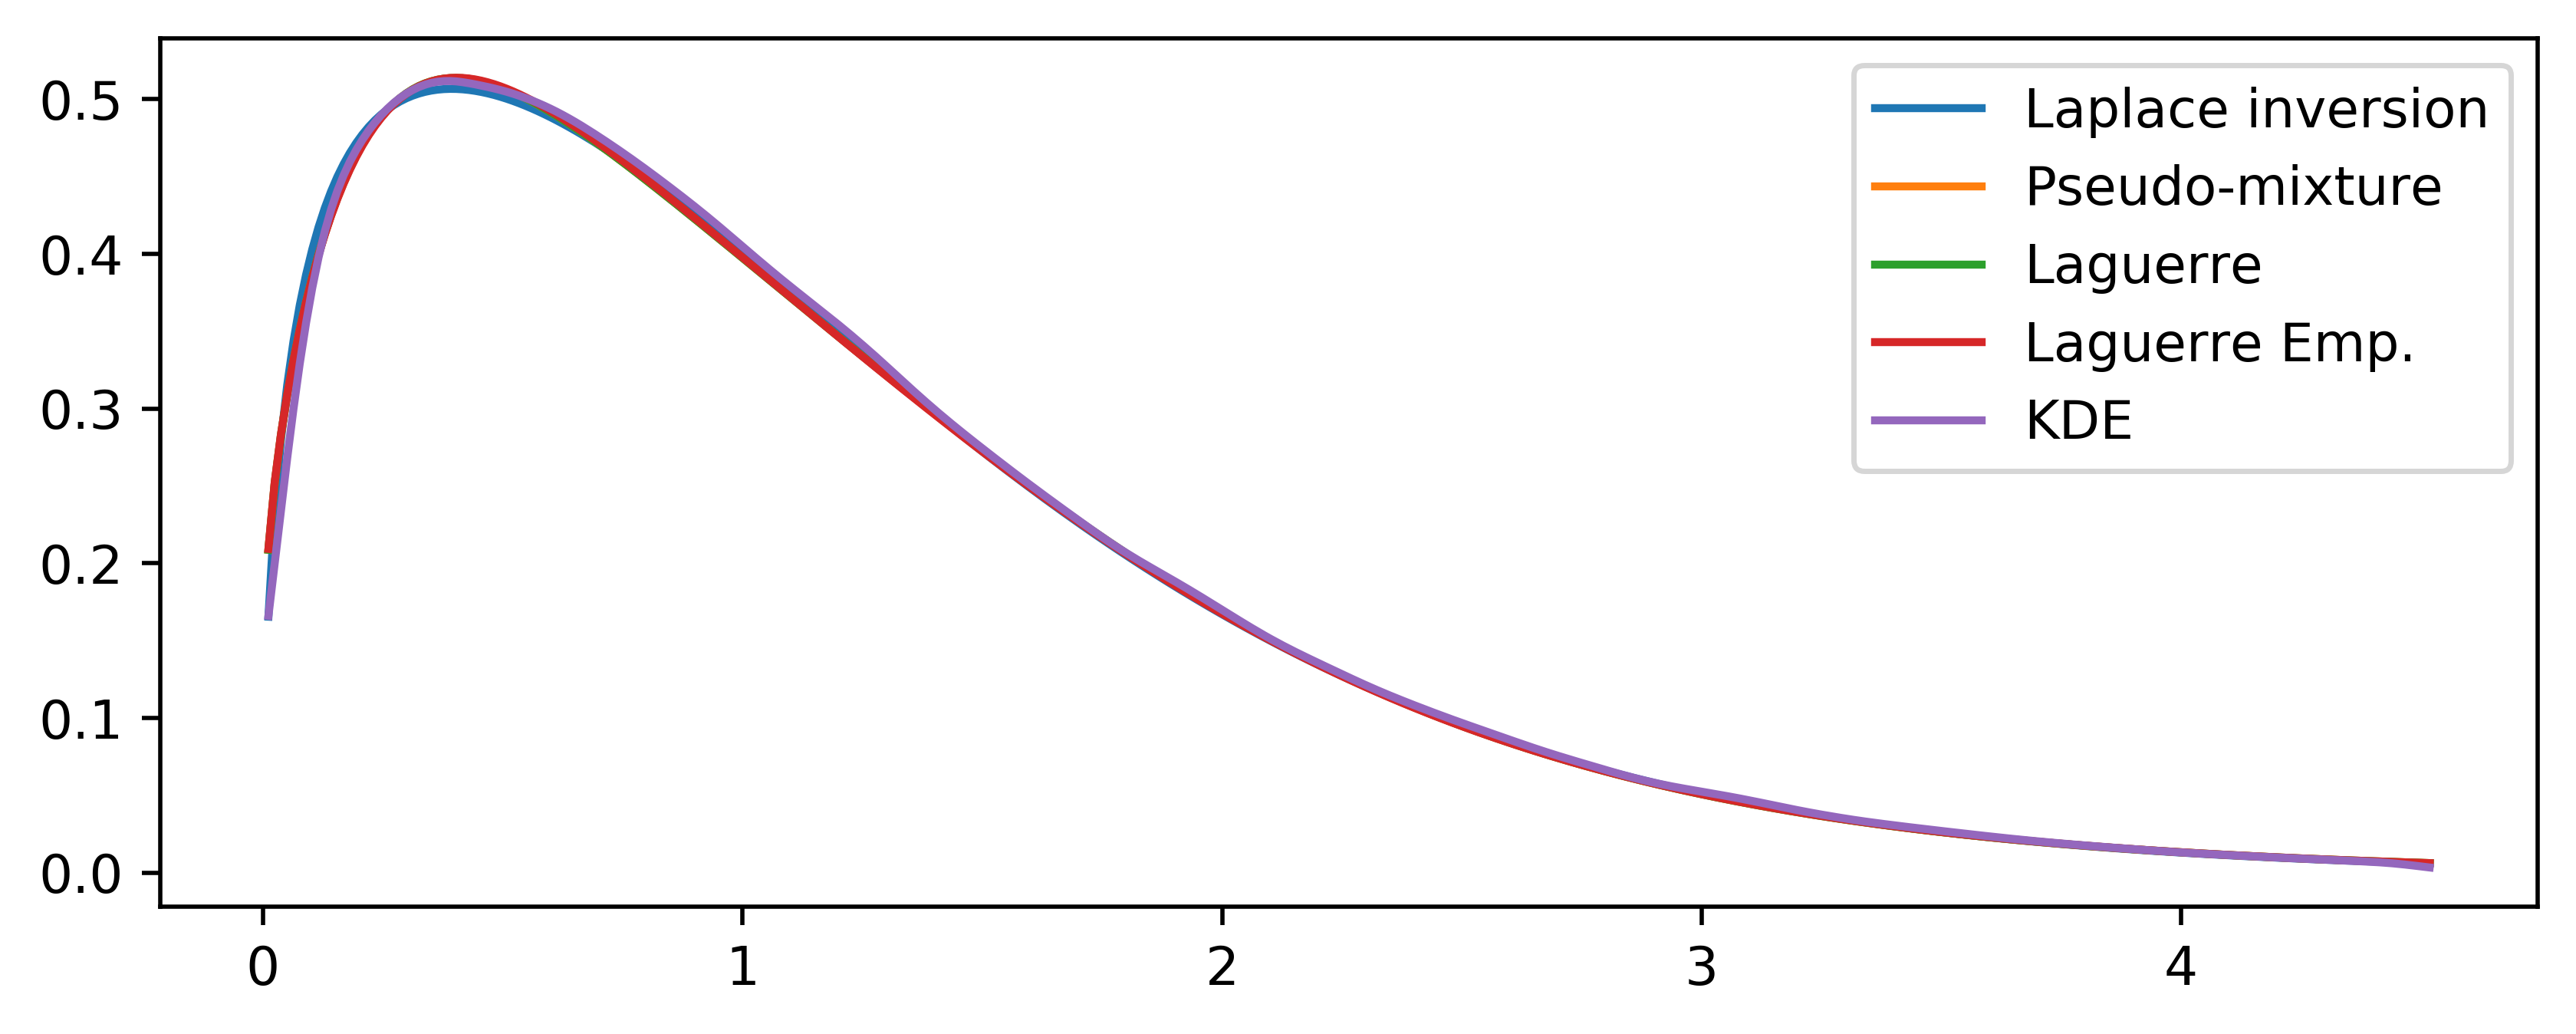

In [41]:
plt.plot(xsPos, pdfsInv, label="Laplace inversion")
plt.plot(xsPos, pdfsPoly, label="Pseudo-mixture")
plt.plot(xsPos, pdfsLag, label="Laguerre")
plt.plot(xsPos, pdfsLagEmp, label="Laguerre Emp.")
if USE_KDE:
    plt.plot(xsPos, pdfsKDE, label="KDE")
#plt.gca().set_xlim((0, xmax))
plt.legend();

In [42]:
pdfsMed = np.median(np.array([pdfsInv, pdfsPoly]), axis=0)

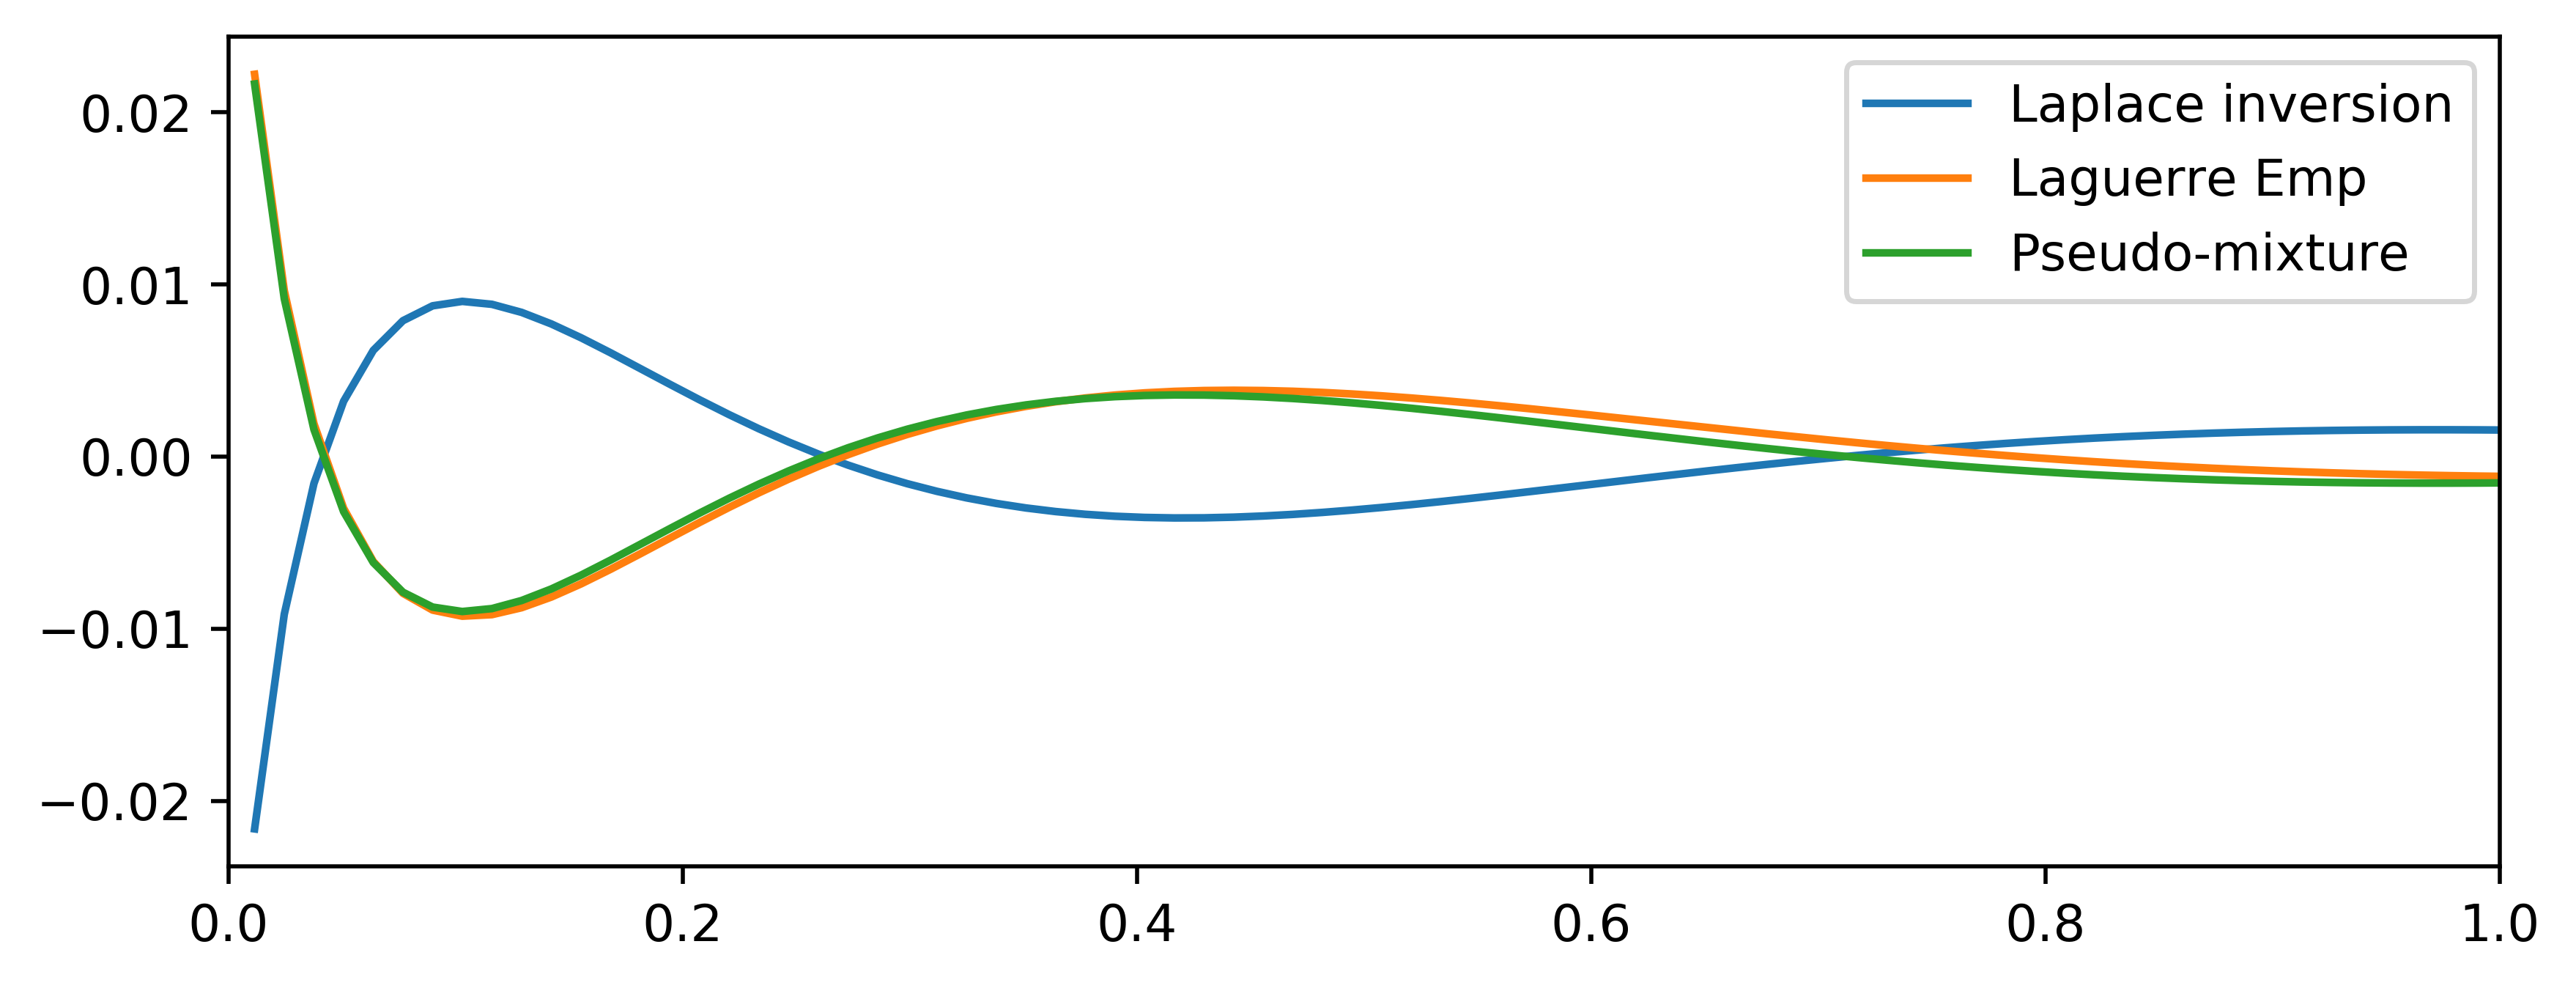

In [43]:
plt.plot(xsPos, pdfsInv-pdfsMed, label="Laplace inversion") 
# plt.plot(xsPos, pdfsLag-pdfsMed, label="Laguerre")
plt.plot(xsPos, pdfsLagEmp-pdfsMed, label="Laguerre Emp")
plt.plot(xsPos, pdfsPoly-pdfsMed, label="Pseudo-mixture")
# if USE_KDE:
#     plt.plot(xsPos, pdfsKDE-pdfsMed, label="KDE")
plt.gca().set_xlim((0, 1))
plt.legend();

In [45]:
svfsPoly = 1 - pcompsum(xsPos, ps, ref_r, ref_m)
svfsInv = svfInv(xsPos)

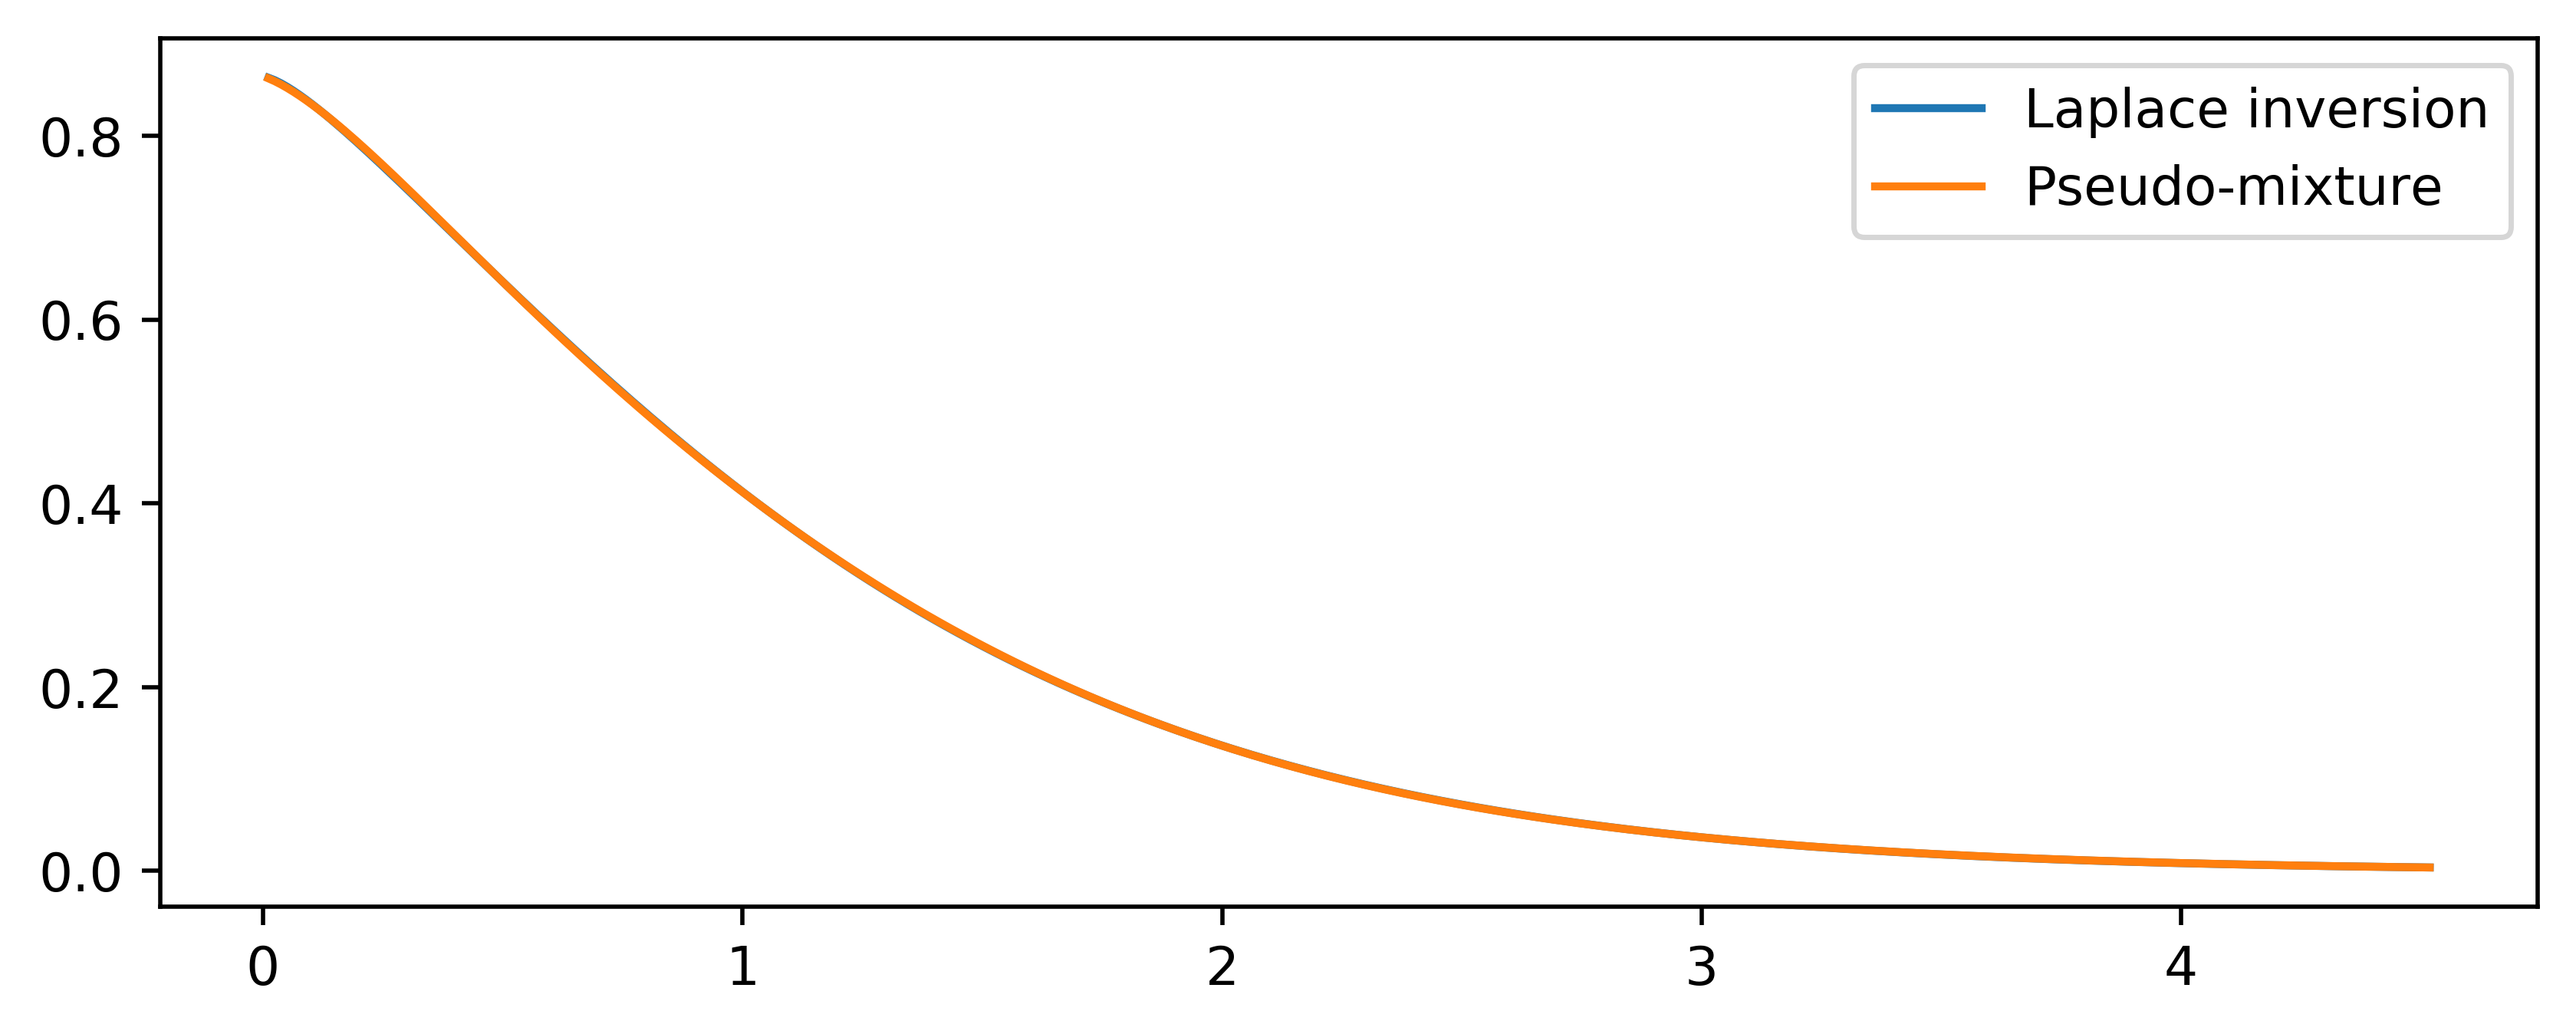

In [46]:
plt.plot(xsPos, svfsInv, label="Laplace inversion")
plt.plot(xsPos, svfsPoly, label="Pseudo-mixture")
plt.legend();

In [47]:
svfsMed = np.median(np.array([svfsPoly, svfsInv]), axis=0)

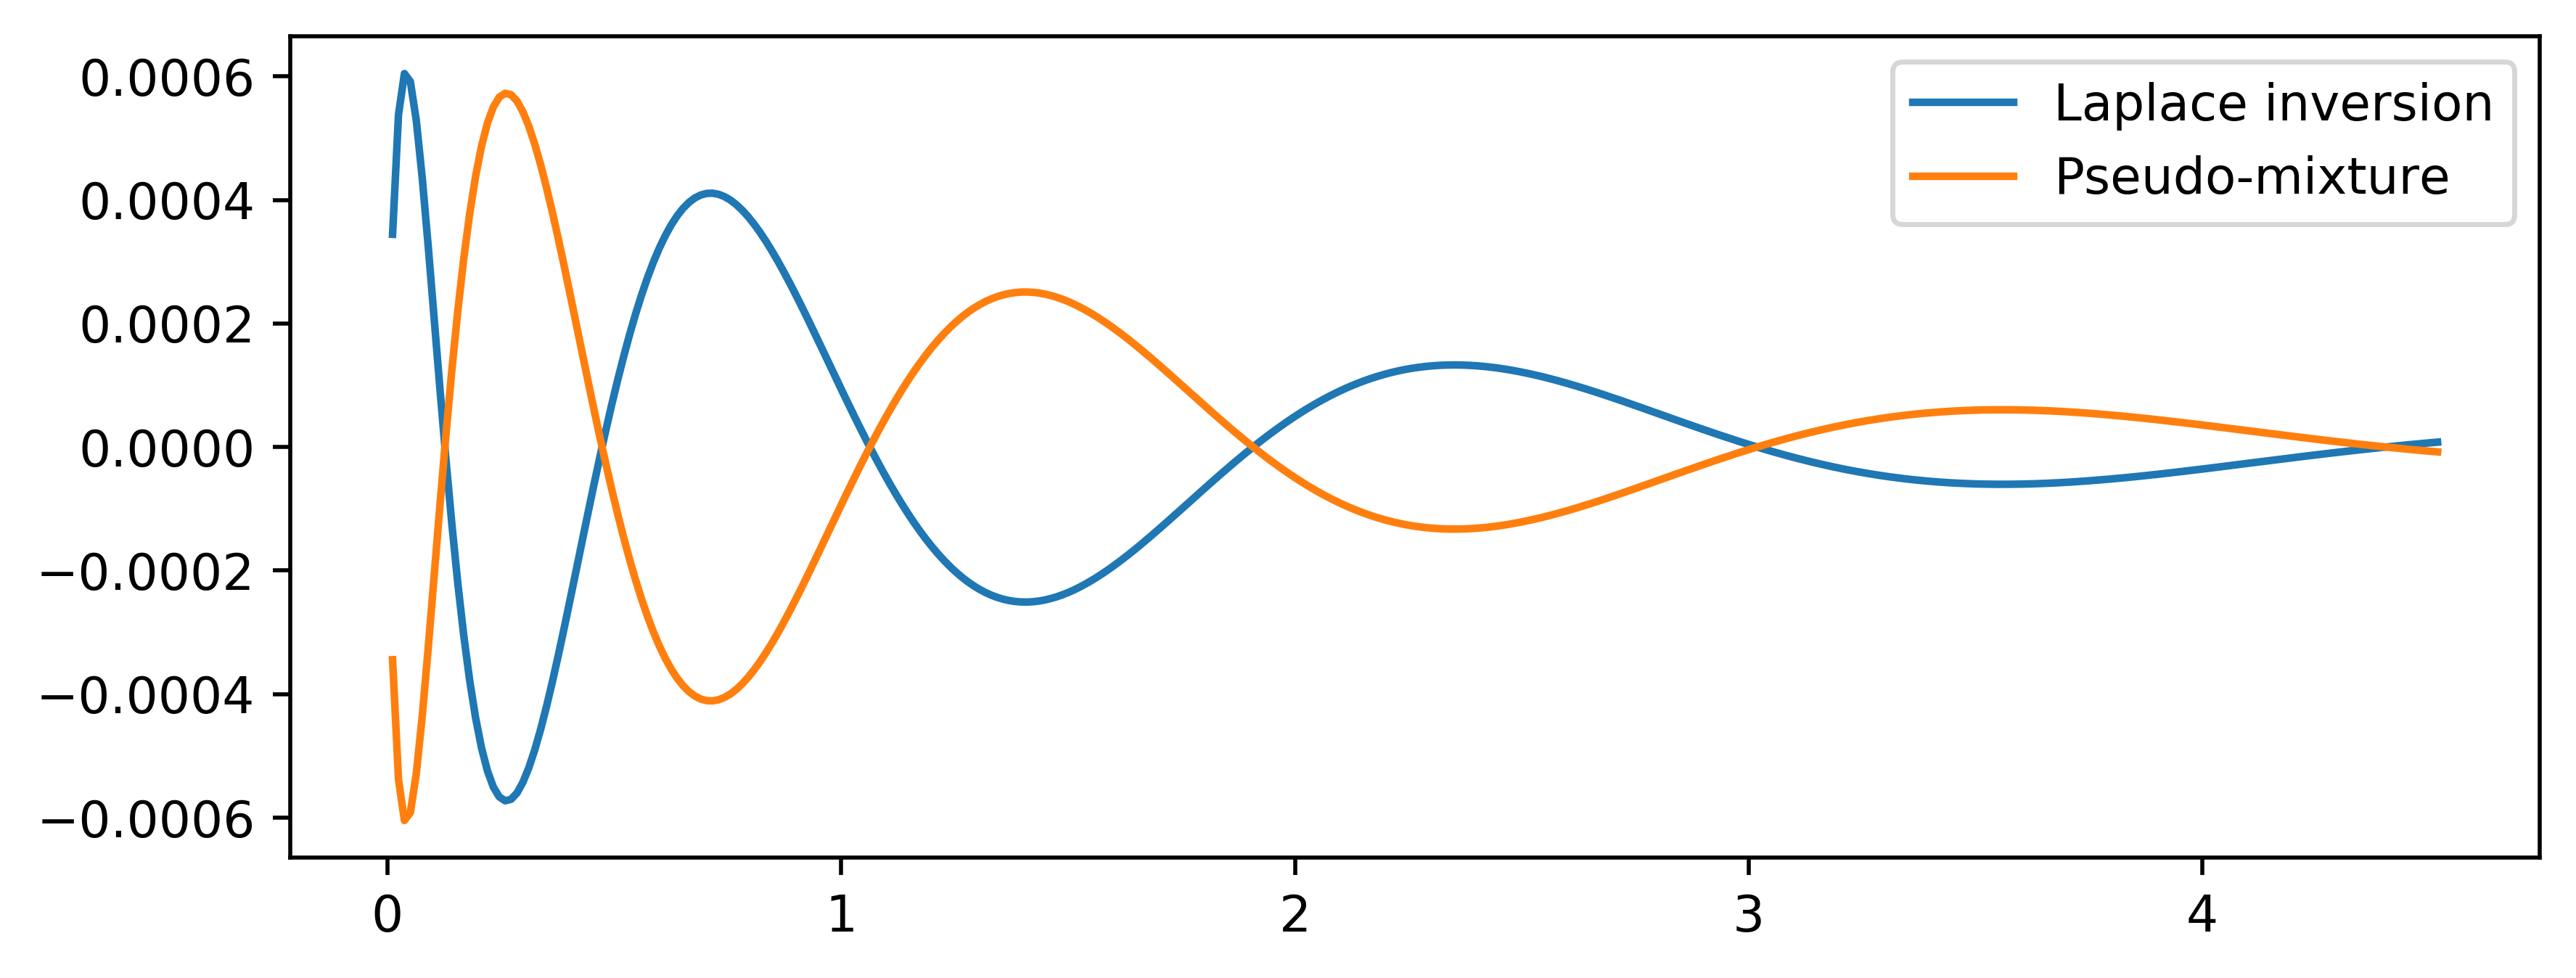

In [48]:
plt.plot(xsPos, svfsInv-svfsMed, label="Laplace inversion")
plt.plot(xsPos, svfsPoly-svfsMed, label="Pseudo-mixture")
plt.legend();

## Test 2: Pascal / Gamma.

In [49]:
N_alpha = 10
N_p = sym.QQ(1, 6)
U_r = sym.QQ(3, 2)
U_m = sym.QQ(1, 75)

N = syms.NegativeBinomial('N', N_alpha, 1-N_p) 
U = syms.Gamma('U', U_r, U_m)

ref_r = 1
s = sym.symbols('s')
U_MGF = rv.moment_generating_function(U)(s)
radOfConv = sym.solvers.solve(U_MGF - 1/(1-N_p), s)[0]
ref_m = 1 / radOfConv
K = 16

S_N_laplace, S_N_plus_laplace = S_N_lts(s, N, U)
S_N_plus_laplace

(s + 75)**15/(59049*(2*(s + 75)**(3/2) - 625*sqrt(3))**10) - 1/60466176

Note, we can't push $K > 4$ using this exact technique, the derivatives get too complicated. Instead we have to drop the infinite precision in parts.

In [50]:
N_alpha = 10
N_p = sym.QQ(1, 6)
U_r = sym.QQ(3, 2)
U_m = 1/75.0  # <---- Here is the change.

N = syms.NegativeBinomial('N', N_alpha, 1-N_p) 
U = syms.Gamma('U', U_r, U_m)

ref_r = 1
s = sym.symbols('s')
U_MGF = rv.moment_generating_function(U)(s)
radOfConv = sym.solvers.solve(U_MGF - 1/(1-N_p), s)[0]
ref_m = 1 / radOfConv
K = 16

S_N_laplace, S_N_plus_laplace = S_N_lts(s, N, U)
S_N_plus_laplace

(0.0133333333333333*s + 1)**15/(60466176*((0.0133333333333333*s + 1)**(3/2) - 0.833333333333333)**10) - 1/60466176

In [51]:
%%time
qs = q_coefficients(S_N_plus_laplace, ref_r, ref_m, K)
qsFloat = [float(q.n(real=True)) for q in qs]
print(qsFloat)

[0.9999999834618107, 7.58383944262483, 25.585624063898294, 50.39594280792666, 63.86517762495395, 53.99791217099826, 30.459103090992215, 11.052866869498986, 2.3412016692382007, 0.22054475037541166, -3.858859676242332e-09, 3.788949376470896e-09, -3.721028596359588e-09, 3.6518501556059846e-09, -3.5884413218667532e-09, 3.513507484953493e-09, -3.4608775845157425e-09]
Wall time: 33.9 ms


In [52]:
ps = p_from_q(qs, ref_r, ref_m)
print(ps)

[ 3.65536804e-07  9.36450474e-06  1.15487174e-04  1.10597913e-03
  7.27980129e-03  3.48861766e-02  1.16854370e-01  2.62949974e-01
  3.56213648e-01  2.20612789e-01 -4.31933548e-05  2.15525293e-05
 -8.27518635e-06  2.36089976e-06 -4.71596364e-07  5.88875488e-08
 -3.46087758e-09]


In [53]:
pdfLT = sym.lambdify(s, S_N_laplace)
cdfLT = sym.lambdify(s, S_N_laplace/s)
svfLT = sym.lambdify(s, (1-S_N_laplace)/s)

pdfInv = np.vectorize(lambda x: transform_inversion(pdfLT, x))
cdfInv = np.vectorize(lambda x: transform_inversion(cdfLT, x))
svfInv = np.vectorize(lambda x: transform_inversion(svfLT, x))

LTStar = (1-S_N_laplace)/(s*syms.E(N)*syms.E(U))
cdfLTStar = sym.lambdify(s, LTStar / s)
svfLTStar = sym.lambdify(s, (1-LTStar) / s)

cdfStarInv = np.vectorize(lambda x: transform_inversion(cdfLTStar, x))
svfStarInv = np.vectorize(lambda x: transform_inversion(svfLTStar, x))

In [54]:
%%time 
rnd.seed(1)
R = int(1e6)

NDist = ss.nbinom(N_alpha, float(N_p))
UDist = ss.gamma(float(U_r), scale=float(U_m))

rvs = rcompsum(R, NDist, UDist)

Wall time: 11.9 s


In [55]:
[syms.E(N), NDist.mean(), syms.E(N**2)-syms.E(N)**2, NDist.var()]

[50, 50.0, 300, 300.0]

In [56]:
[syms.E(U), UDist.mean(), syms.E(U**2)-syms.E(U)**2, UDist.var()]

[0.0200000000000000, 0.02, 0.000266666666666667, 0.0002666666666666667]

In [57]:
posRVs = np.array([x for x in rvs if x > 0])
p_0 = (R - len(posRVs)) / R

In [58]:
xMax = np.max(rvs) / 2
xs = np.linspace(-2, xMax, 500)
xsPos = xs[xs > 0]

ref_r = float(ref_r)
ref_m = float(ref_m)

pdfsInv = pdfInv(xsPos)
pdfsPoly = dcompsum(xsPos, ps, ref_r, ref_m)

qsEmp = (1-p_0) * q_coefficients_empirically(posRVs, K, ref_r, ref_m)

pdfsLag = laguerre_expansion(qsFloat, xsPos, ref_r, ref_m)
pdfsLagEmp = laguerre_expansion(qsEmp, xsPos, ref_r, ref_m)

In [59]:
if USE_KDE:
    pdfsKDEAll = kde.ssvkernel(posRVs, xs, nbs=1)[0]
    probNeg = np.sum(pdfsKDEAll[xs <= 0] * (xs[1] - xs[0]))
    pdfsKDE = pdfsKDEAll[xs > 0] * (1 - p_0) / (1 - probNeg)
    print(f"probNeg={probNeg} scaling={(1 - p_0) / (1 - probNeg)}")

probNeg=1.275441008456426e-06 scaling=1.0000012754426353


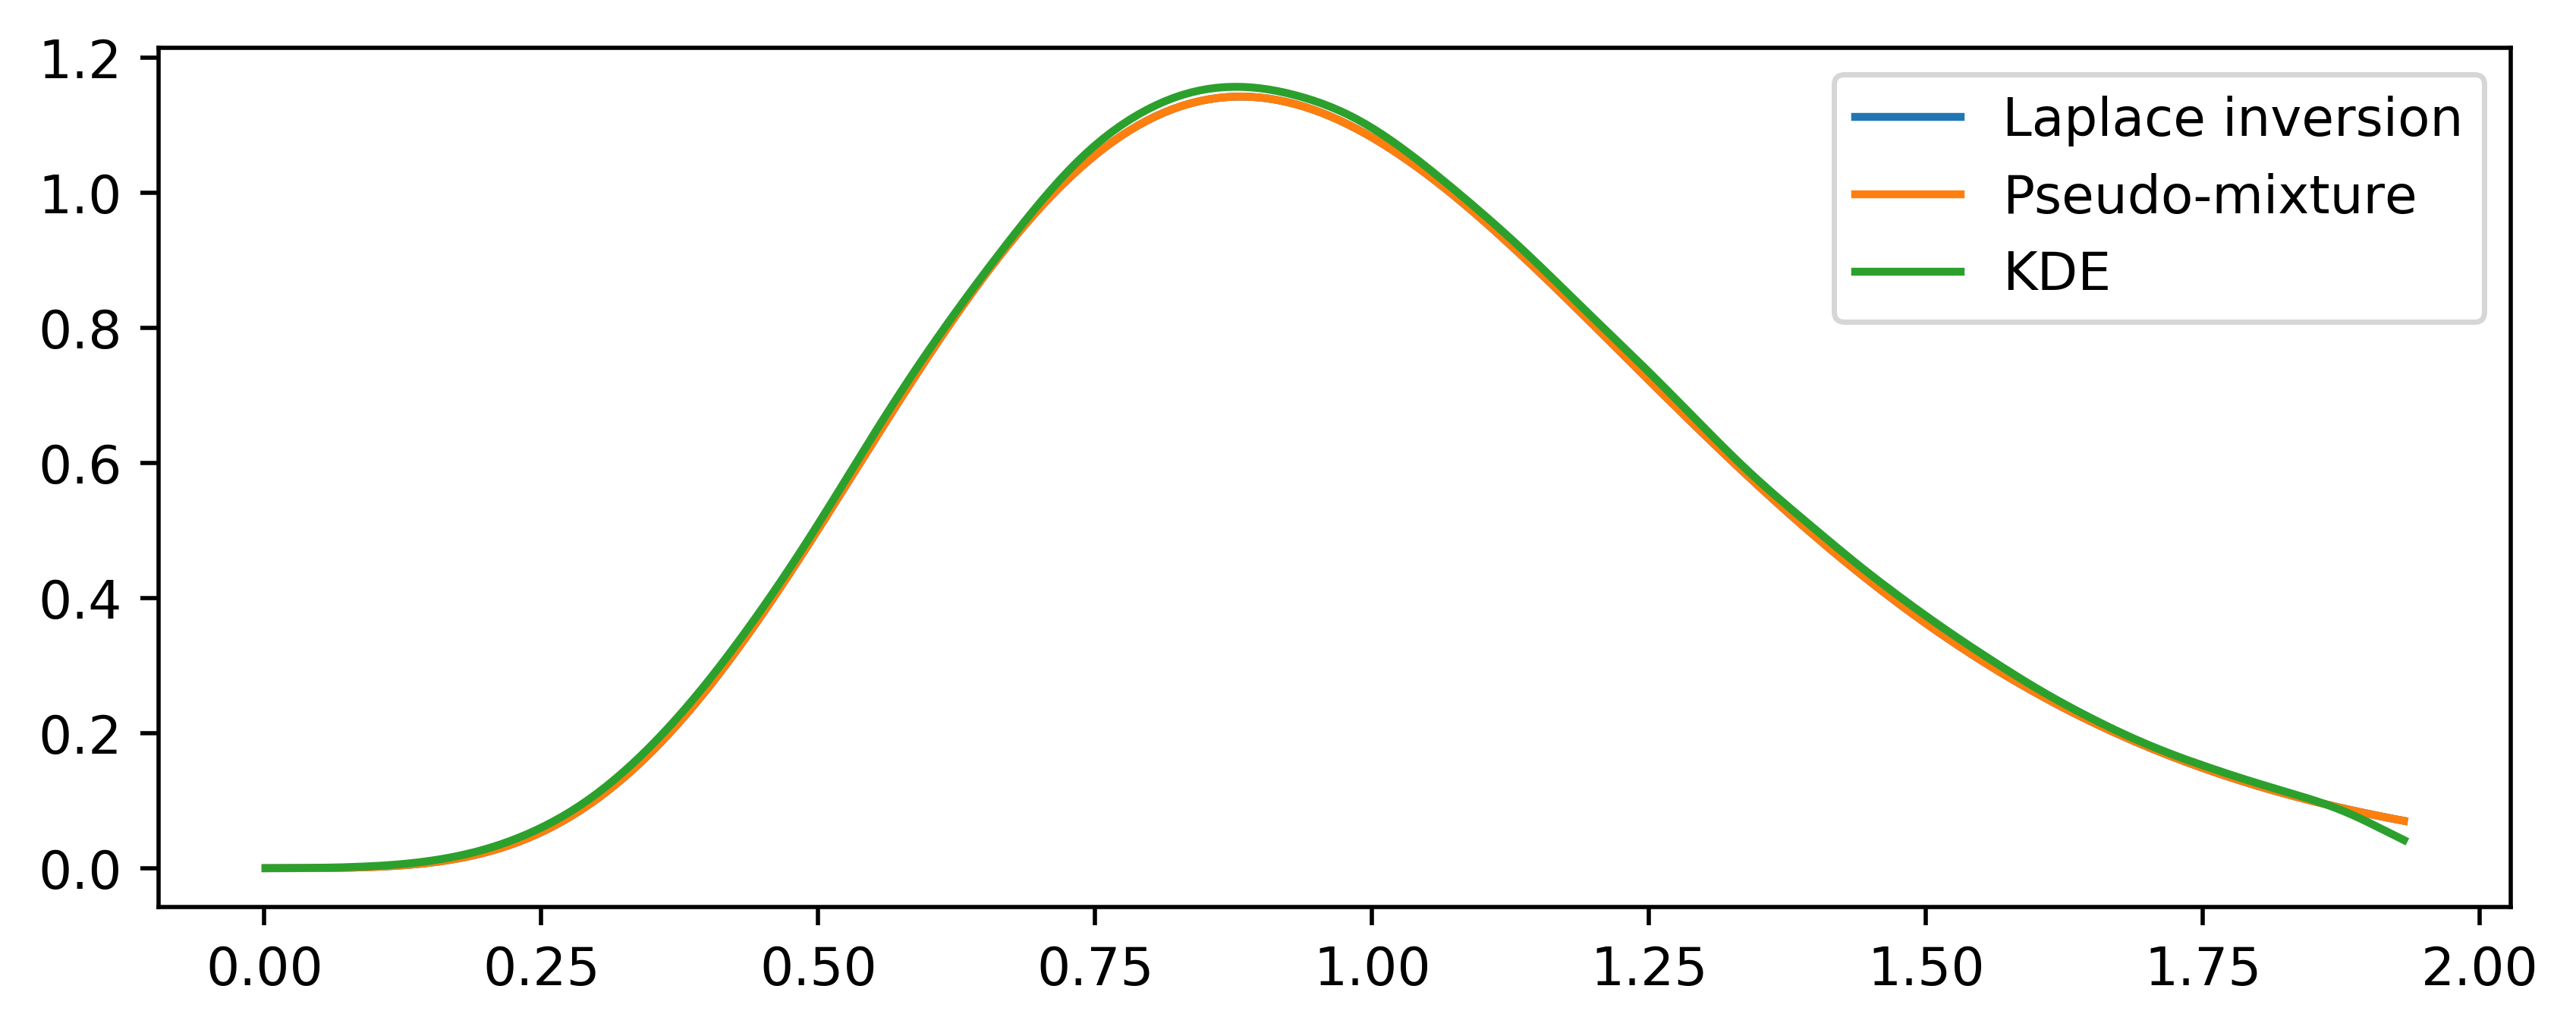

In [60]:
plt.plot(xsPos, pdfsInv, label="Laplace inversion")
plt.plot(xsPos, pdfsPoly, label="Pseudo-mixture")
#plt.plot(xsPos, pdfsLag, label="Laguerre")
#plt.plot(xsPos, pdfsLagEmp, label="Laguerre Emp.")
if USE_KDE:
    plt.plot(xsPos, pdfsKDE, label="KDE")
#plt.gca().set_xlim((0, xmax))
plt.legend();

In [61]:
pdfsMed = np.median(np.array([pdfsInv, pdfsPoly]), axis=0)

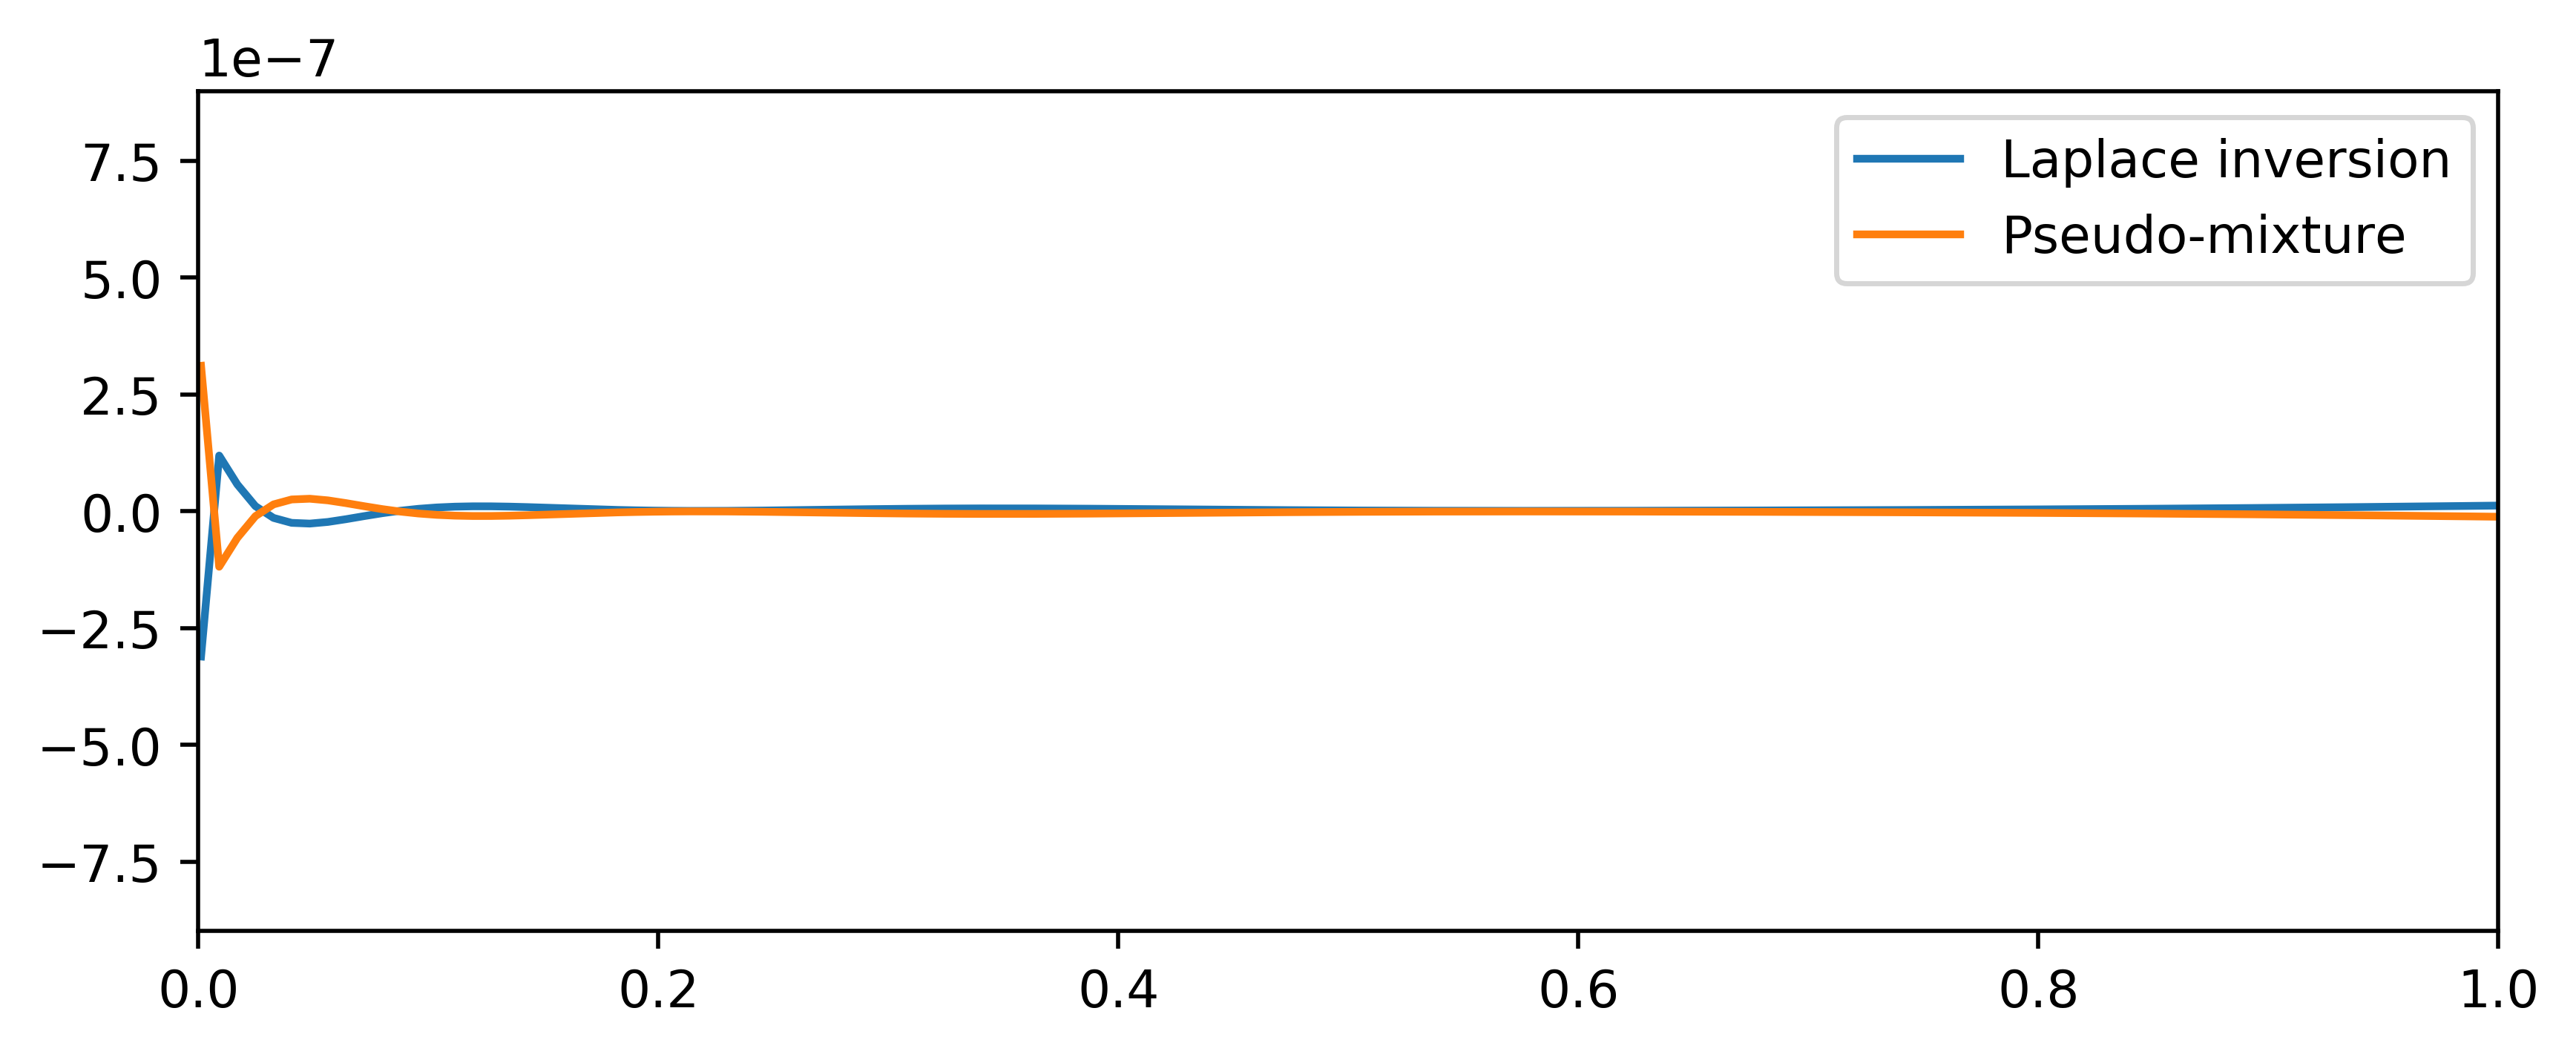

In [62]:
plt.plot(xsPos, pdfsInv-pdfsMed, label="Laplace inversion") 
#plt.plot(xsPos, pdfsLag-pdfsMed, label="Laguerre")
#plt.plot(xsPos, pdfsLagEmp-pdfsMed, label="Laguerre Emp")
plt.plot(xsPos, pdfsPoly-pdfsMed, label="Pseudo-mixture")
# if USE_KDE:
#     plt.plot(xsPos, pdfsKDE-pdfsMed, label="KDE")
plt.gca().set_xlim((0, 1))
plt.legend();

In [63]:
svfsPoly = 1 - pcompsum(xsPos, ps, ref_r, ref_m)
svfsInv = svfInv(xsPos)

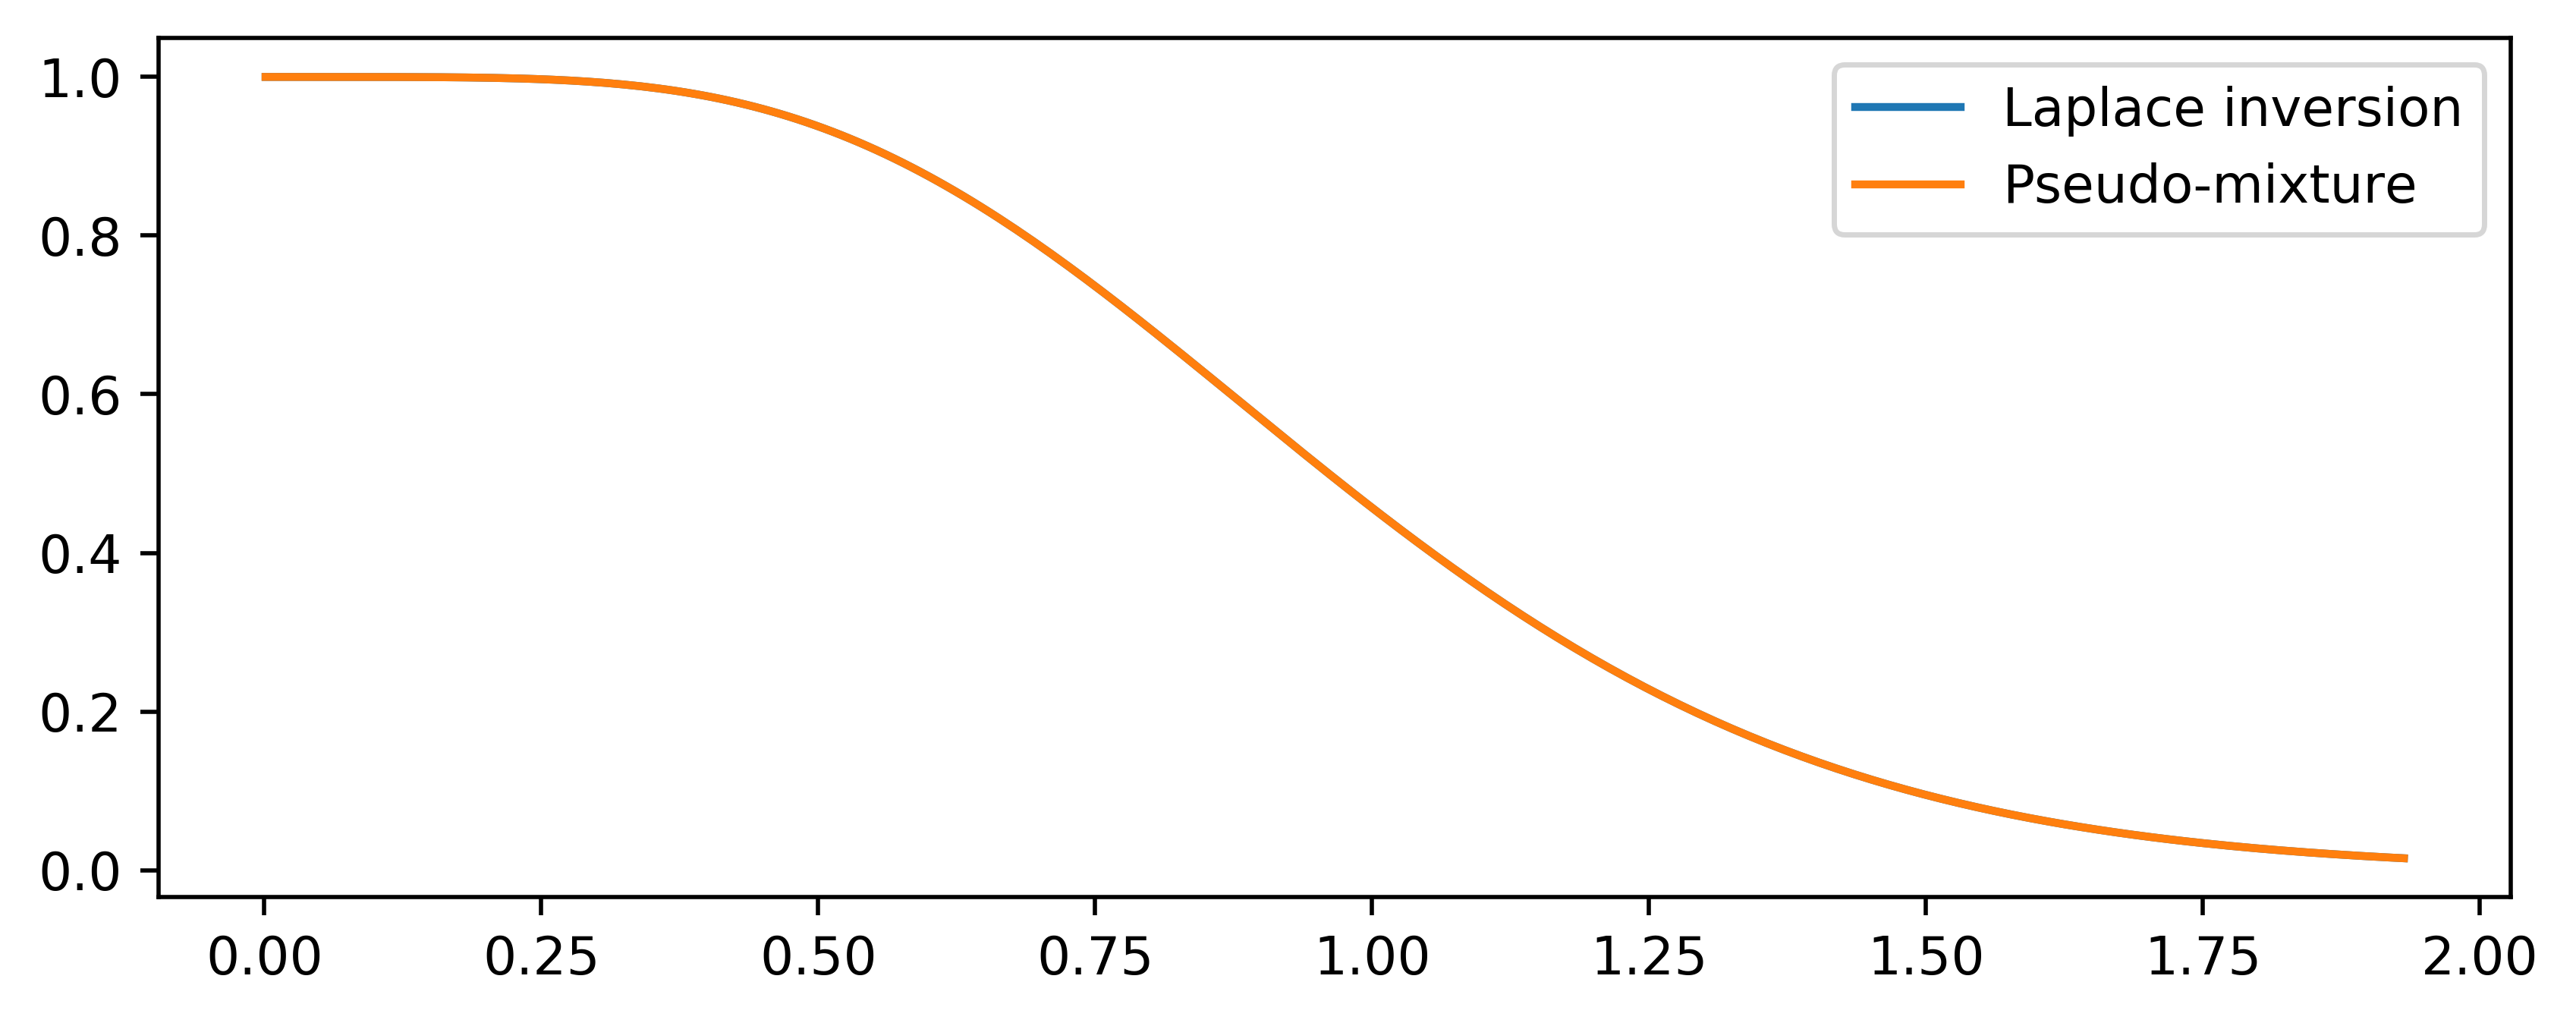

In [64]:
plt.plot(xsPos, svfsInv, label="Laplace inversion")
plt.plot(xsPos, svfsPoly, label="Pseudo-mixture")
plt.legend();

In [65]:
svfsMed = np.median(np.array([svfsPoly, svfsInv]), axis=0)

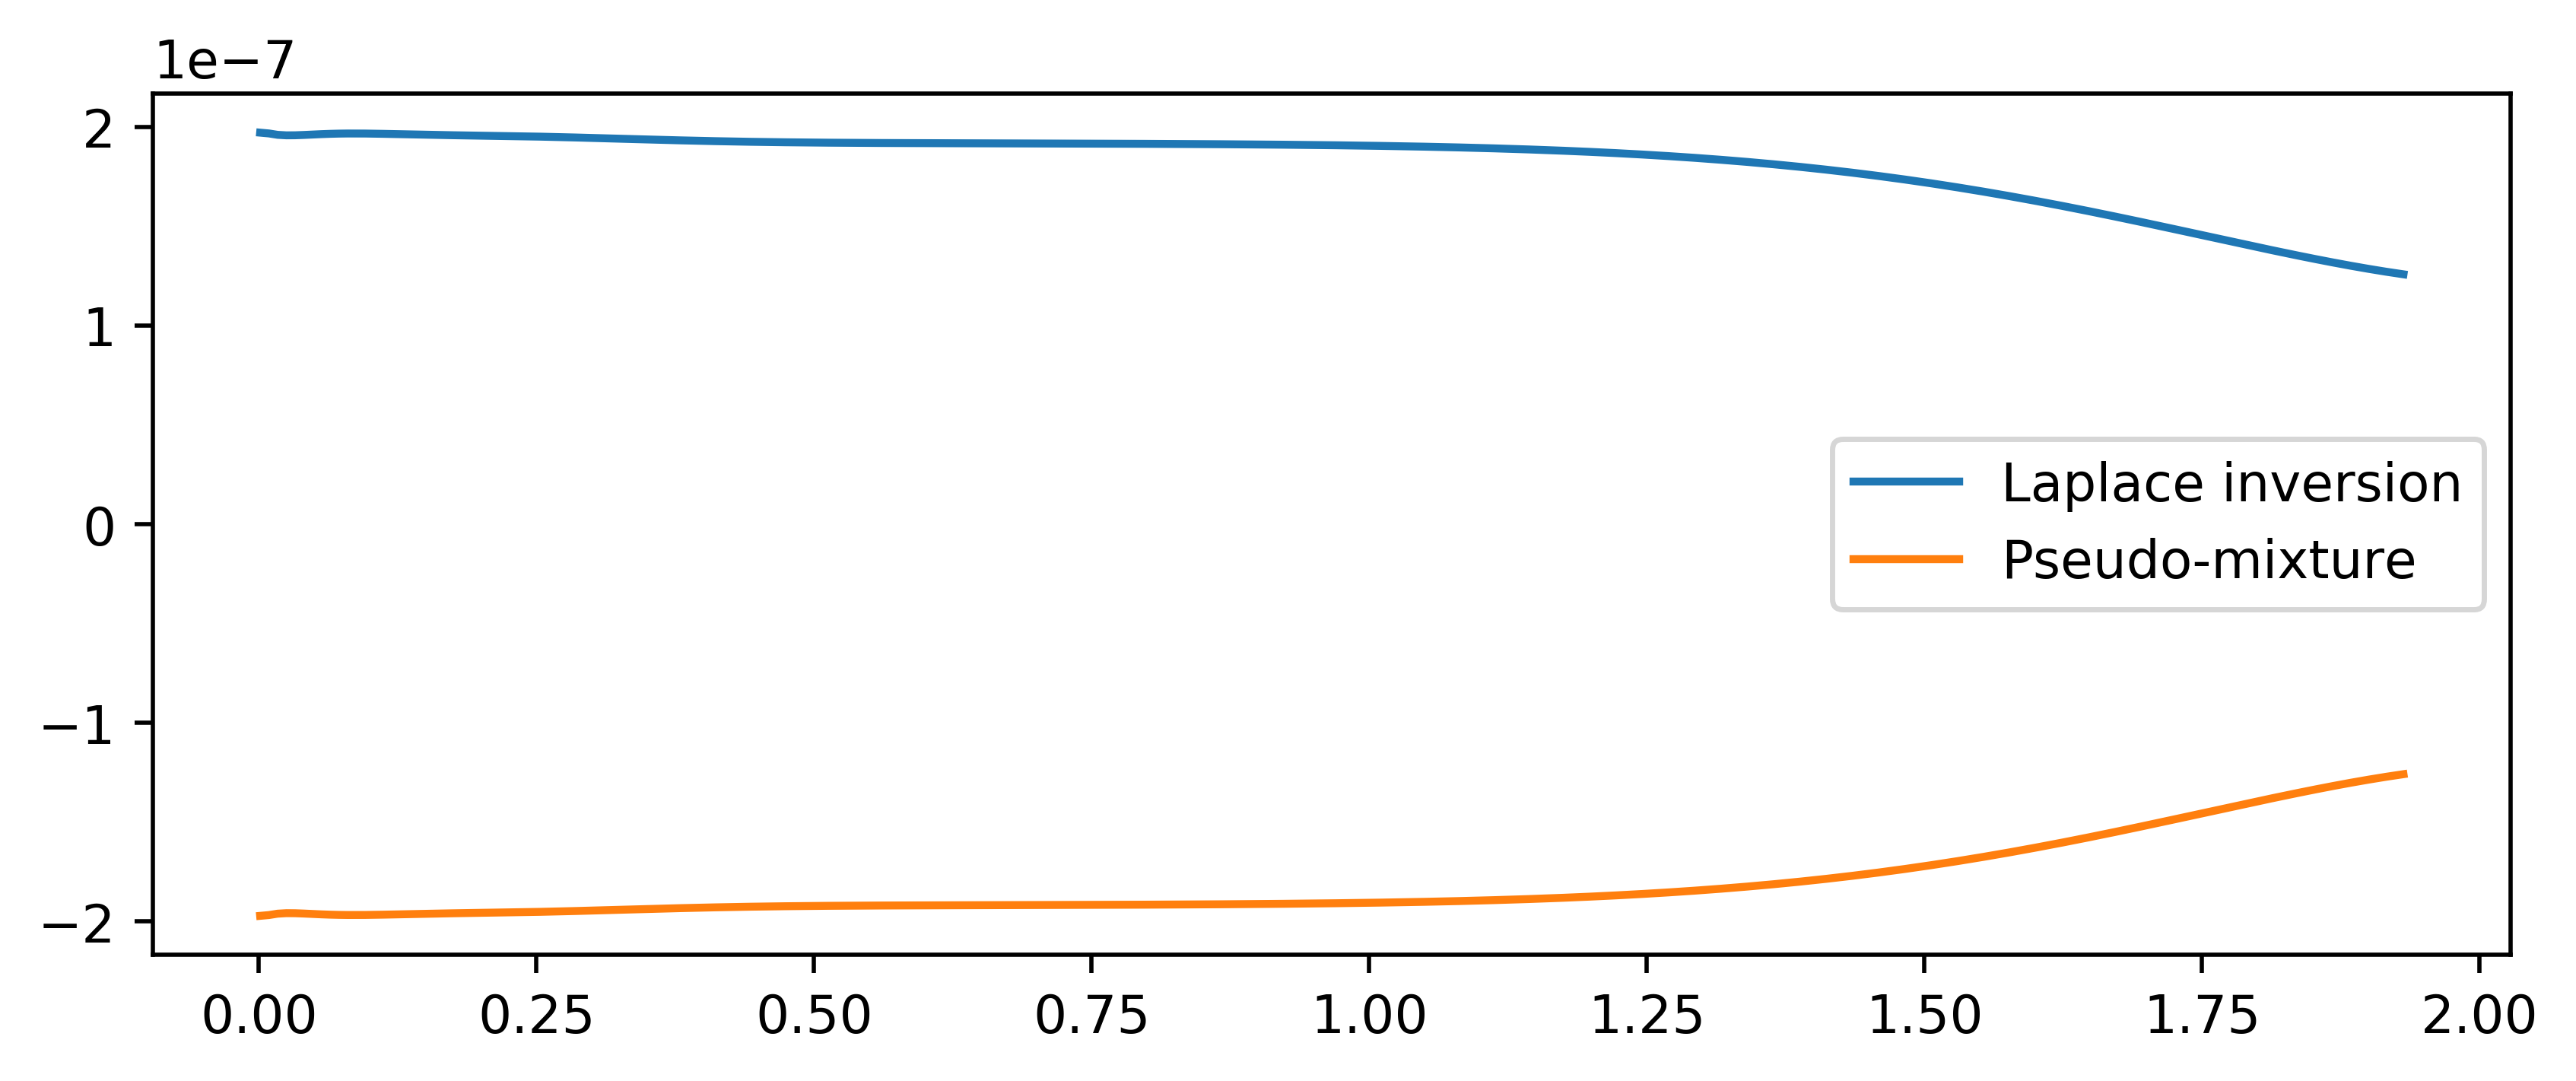

In [66]:
plt.plot(xsPos, svfsInv-svfsMed, label="Laplace inversion")
plt.plot(xsPos, svfsPoly-svfsMed, label="Pseudo-mixture")
plt.legend();

## Test 3: Poisson / Pareto.

In [67]:
N_lambda = 4
U_a = 5
U_b = 11

N = syms.Poisson('N', N_lambda)
U = syms.Pareto('U', alpha=U_b, xm=U_a) - U_a

ref_r = syms.E(U)
tilt = 1
tilt_frac = sym.QQ(1, 2)
ref_m_orig = tilt_frac / tilt
ref_m = ref_m_orig / (1 - ref_m_orig * tilt)

K = 2

s = sym.symbols('s', real=True)
S_N_laplace, S_N_plus_laplace = S_N_lts(s, N, U, tilt)
S_N_plus_laplace

(exp(44*exp(5*s + 5)*expint(12, 5*s + 5)) - 1)*exp(-4)

In [68]:
[ref_r, ref_m_orig, ref_m]

[1/2, 1/2, 1]

In [69]:
%%time
# NOTE!! The "m_orig" is used here
qs = q_coefficients(S_N_plus_laplace, ref_r, ref_m_orig, K, fast=False)
qsFloat = [float(sym.re(q.n().subs(sym.exp_polar, sym.exp))) for q in qs]
print(qsFloat)

[0.2531860998449624, 0.4818354305514488, 0.17453840947155186]
Wall time: 10.7 s


In [70]:
ps = p_from_q(qs, ref_r, ref_m_orig, tilt, fast=False)
print(ps)

[0.02734869 0.35913255 0.6045076 ]


In [71]:
s = S_N_laplace.free_symbols.pop()
pdfLT = lambda x: float(sym.re(S_N_laplace.subs(s, x).n()))
cdfLT = lambda x: float(sym.re((S_N_laplace.subs(s, x)/x).n()))
#cdfLT = sym.lambdify(s, S_N_laplace/s)
svfLT = sym.lambdify(s, (1-S_N_laplace)/s)

#pdfInv = np.vectorize(lambda x: transform_inversion(pdfLT, x))

#cdfInv = np.vectorize(lambda x: transform_inversion(cdfLT, x))
svfInv = np.vectorize(lambda x: transform_inversion(svfLT, x))

LTStar = (1-S_N_laplace)/(s*syms.E(N)*syms.E(U))
cdfLTStar = sym.lambdify(s, LTStar / s)
svfLTStar = sym.lambdify(s, (1-LTStar) / s)

cdfStarInv = np.vectorize(lambda x: transform_inversion(cdfLTStar, x))

svfStarInv = np.vectorize(lambda x: transform_inversion(svfLTStar, x))

In [72]:
[pdfLT(0.5), pdfLT(1.0), pdfLT(2.0), pdfLT(3.0), pdfLT(40.0)]

[0.45528720909602893,
 0.27150173873369654,
 0.14209321082075482,
 0.09592362418698064,
 0.022541485043230645]

In [73]:
%%time 
rnd.seed(1)
R = int(1e6)

NDist = ss.poisson(N_lambda)
UDist = ss.pareto(U_b, scale=U_a, loc=-U_a)

rvs = rcompsum(R, NDist, UDist)

Wall time: 7.5 s


In [74]:
[syms.E(N), NDist.mean(), syms.E(N**2)-syms.E(N)**2, NDist.var()]

[4, 4.0, 4, 4.0]

In [75]:
[syms.E(U).n(), UDist.mean(), (syms.E(U**2)-syms.E(U)**2).n(), UDist.var()]

[0.500000000000000, 0.5, 0.305555555555556, 0.3055555555555556]

In [76]:
posRVs = np.array([x for x in rvs if x > 0])
p_0 = (R - len(posRVs)) / R

In [77]:
xMax = np.max(rvs) / 2
xs = np.linspace(-2, xMax, 500)
xsPos = xs[xs > 0]

ref_r = float(ref_r)
ref_m = float(ref_m)

pdfsInv = np.array([pdfLT(x) for x in xsPos])
pdfsPoly = dcompsum(xsPos, ps, ref_r, ref_m)

qsEmp = (1-p_0) * q_coefficients_empirically(posRVs, K, ref_r, ref_m)

pdfsLag = laguerre_expansion(qsFloat, xsPos, ref_r, ref_m)
pdfsLagEmp = laguerre_expansion(qsEmp, xsPos, ref_r, ref_m)

In [78]:
if USE_KDE:
    pdfsKDEAll = kde.ssvkernel(posRVs, xs, nbs=1)[0]
    probNeg = np.sum(pdfsKDEAll[xs <= 0] * (xs[1] - xs[0]))
    pdfsKDE = pdfsKDEAll[xs > 0] * (1 - p_0) / (1 - probNeg)
    print(f"probNeg={probNeg} scaling={(1 - p_0) / (1 - probNeg)}")

probNeg=0.00754362251538598 scaling=0.9893674143025217


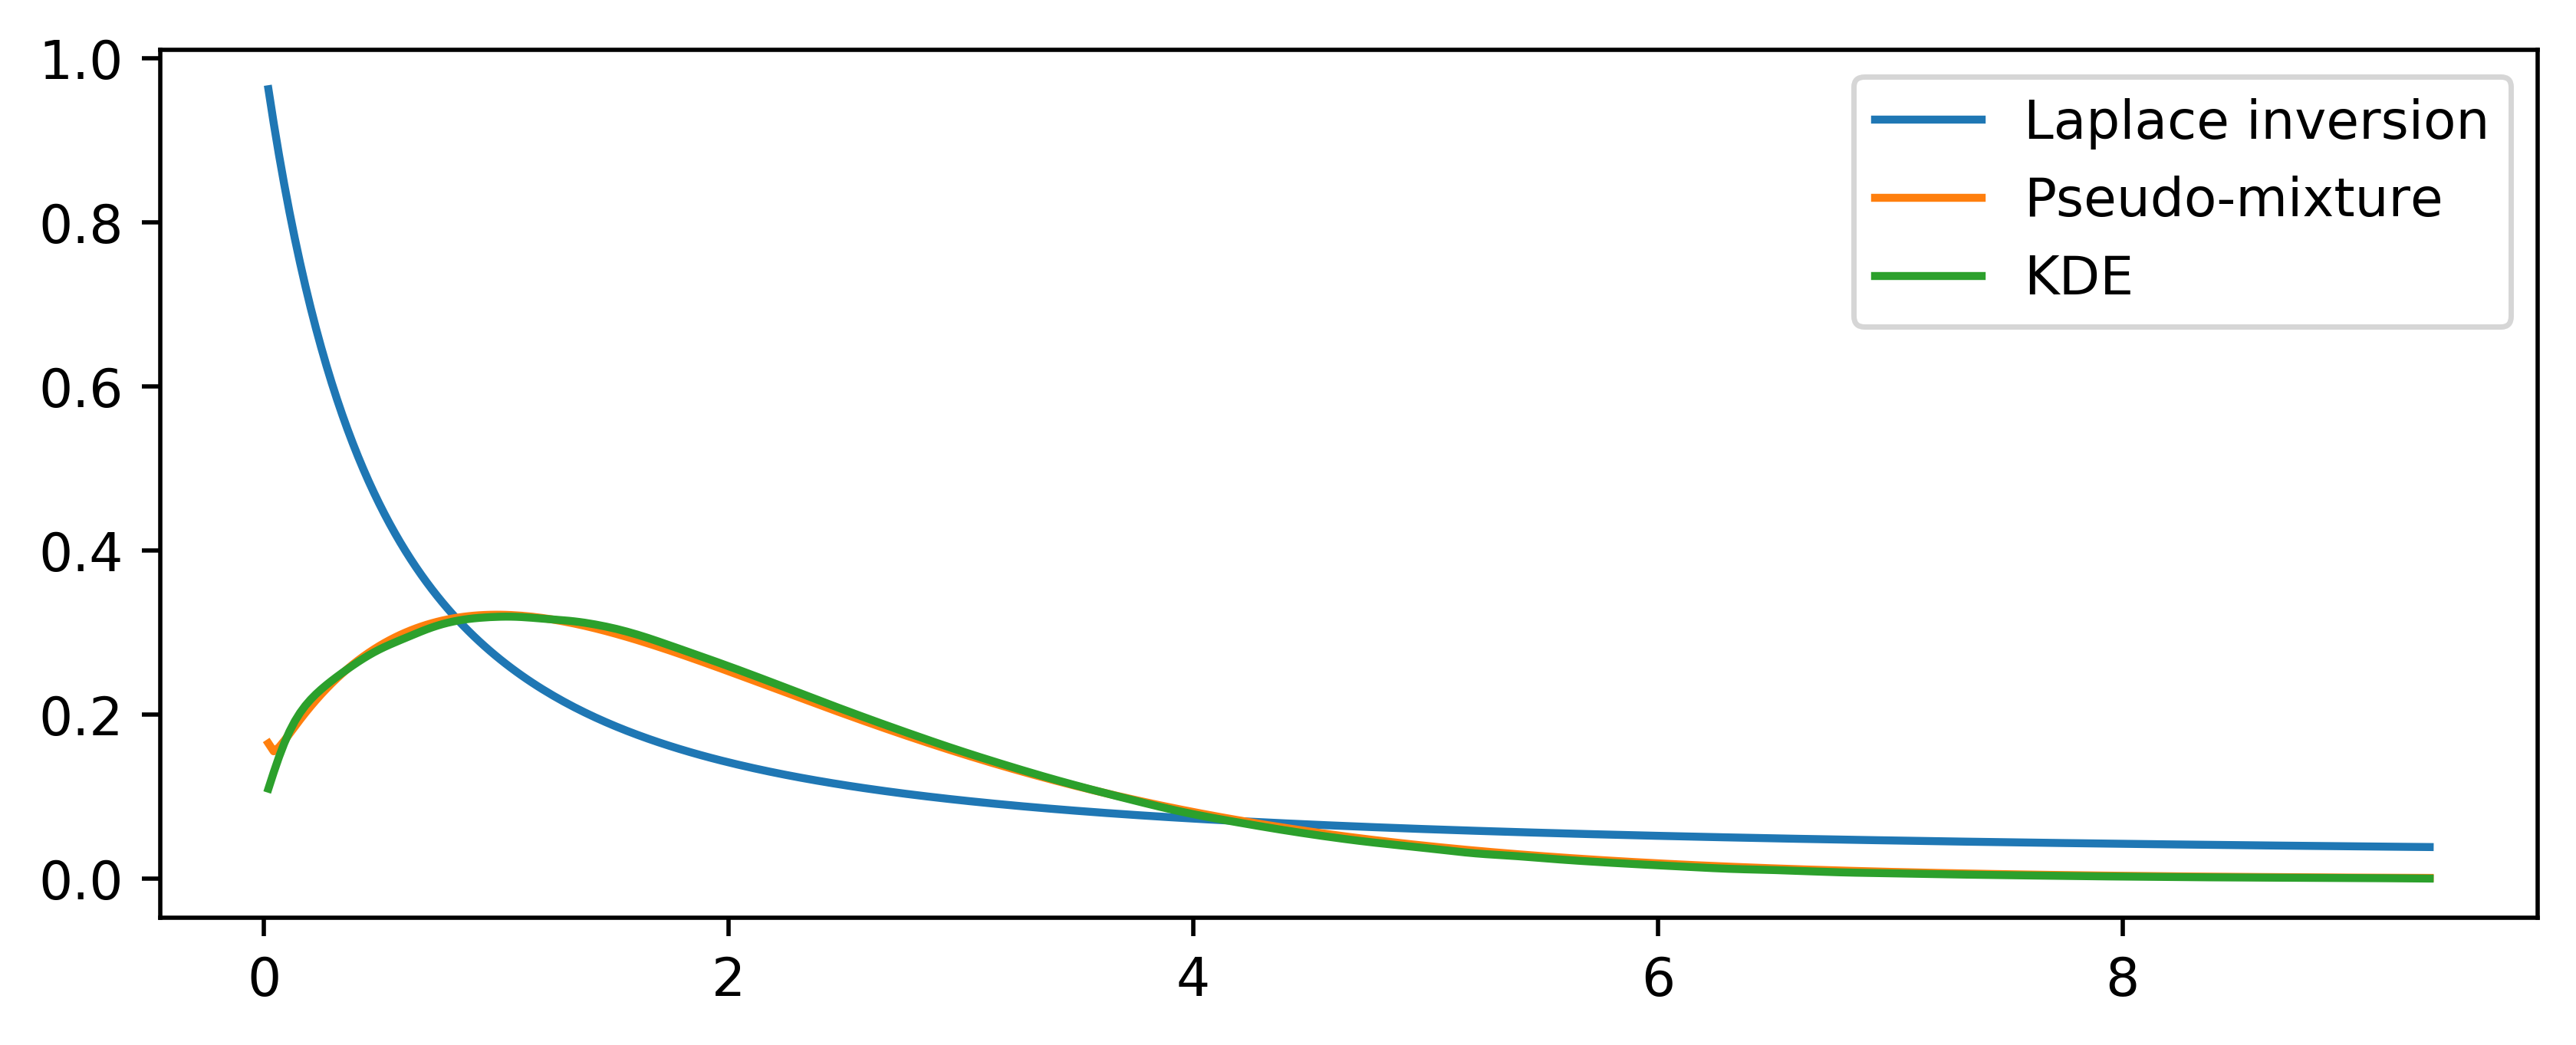

In [79]:
plt.plot(xsPos, pdfsInv, label="Laplace inversion")
plt.plot(xsPos, pdfsPoly, label="Pseudo-mixture")
#plt.plot(xsPos, pdfsLag, label="Laguerre")
#plt.plot(xsPos, pdfsLagEmp, label="Laguerre Emp.")
if USE_KDE:
    plt.plot(xsPos, pdfsKDE, label="KDE")
#plt.gca().set_xlim((0, xmax))
plt.legend();

In [80]:
pdfsMed = np.median(np.array([pdfsInv, pdfsPoly]), axis=0)

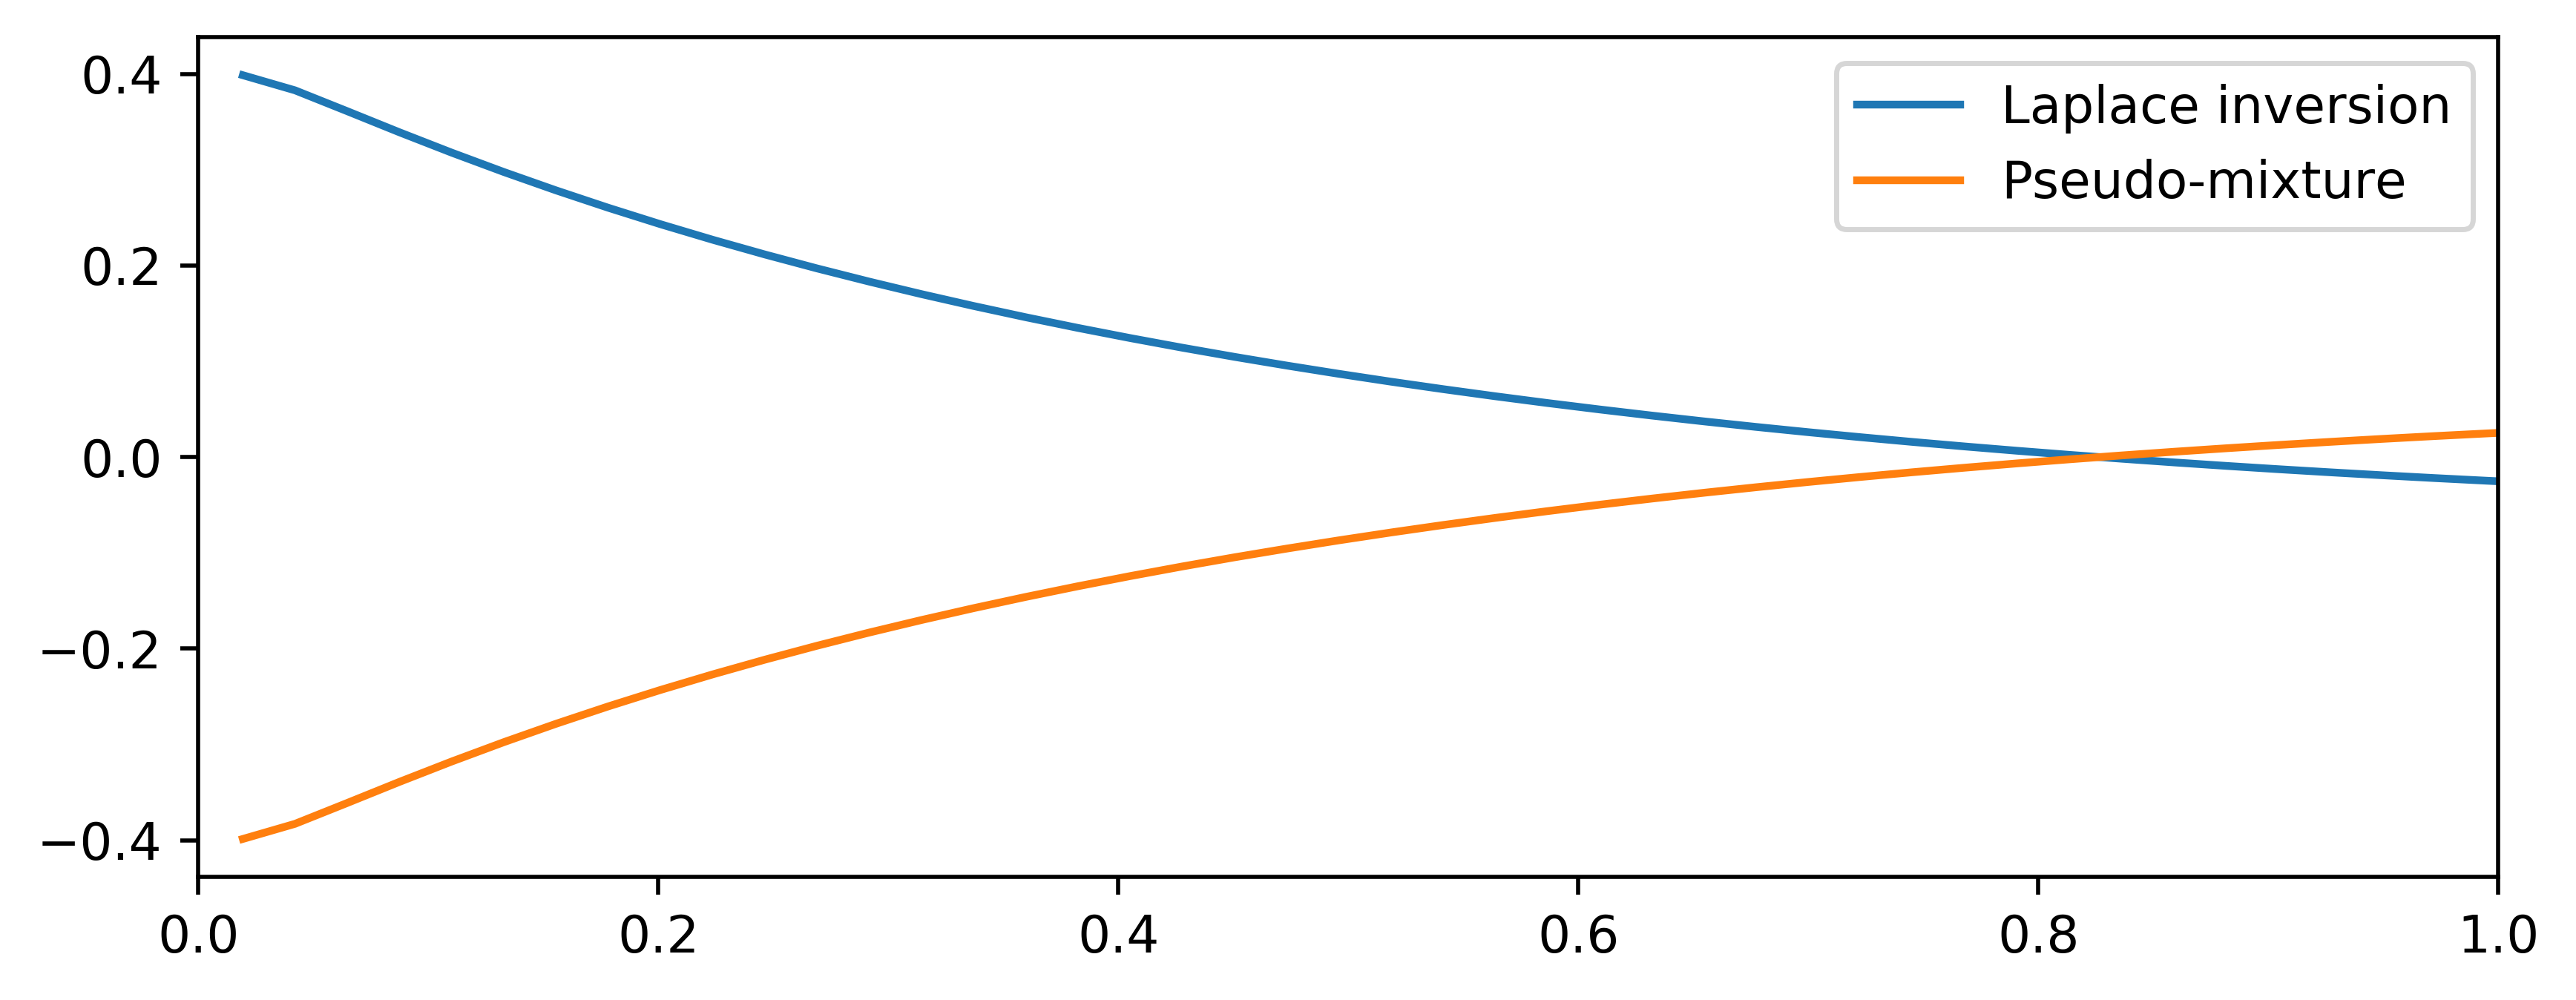

In [81]:
plt.plot(xsPos, pdfsInv-pdfsMed, label="Laplace inversion") 
#plt.plot(xsPos, pdfsLag-pdfsMed, label="Laguerre")
#plt.plot(xsPos, pdfsLagEmp-pdfsMed, label="Laguerre Emp")
plt.plot(xsPos, pdfsPoly-pdfsMed, label="Pseudo-mixture")
# if USE_KDE:
#     plt.plot(xsPos, pdfsKDE-pdfsMed, label="KDE")
plt.gca().set_xlim((0, 1))
plt.legend();

In [84]:
svfsPoly = 1 - pcompsum(xsPos, ps, ref_r, ref_m)
svfsInv = svfInv(xsPos)

<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in cdouble_scalars


NameError: name 'expint' is not defined

ValueError: x and y must have same first dimension, but have shapes (411,) and (246,)

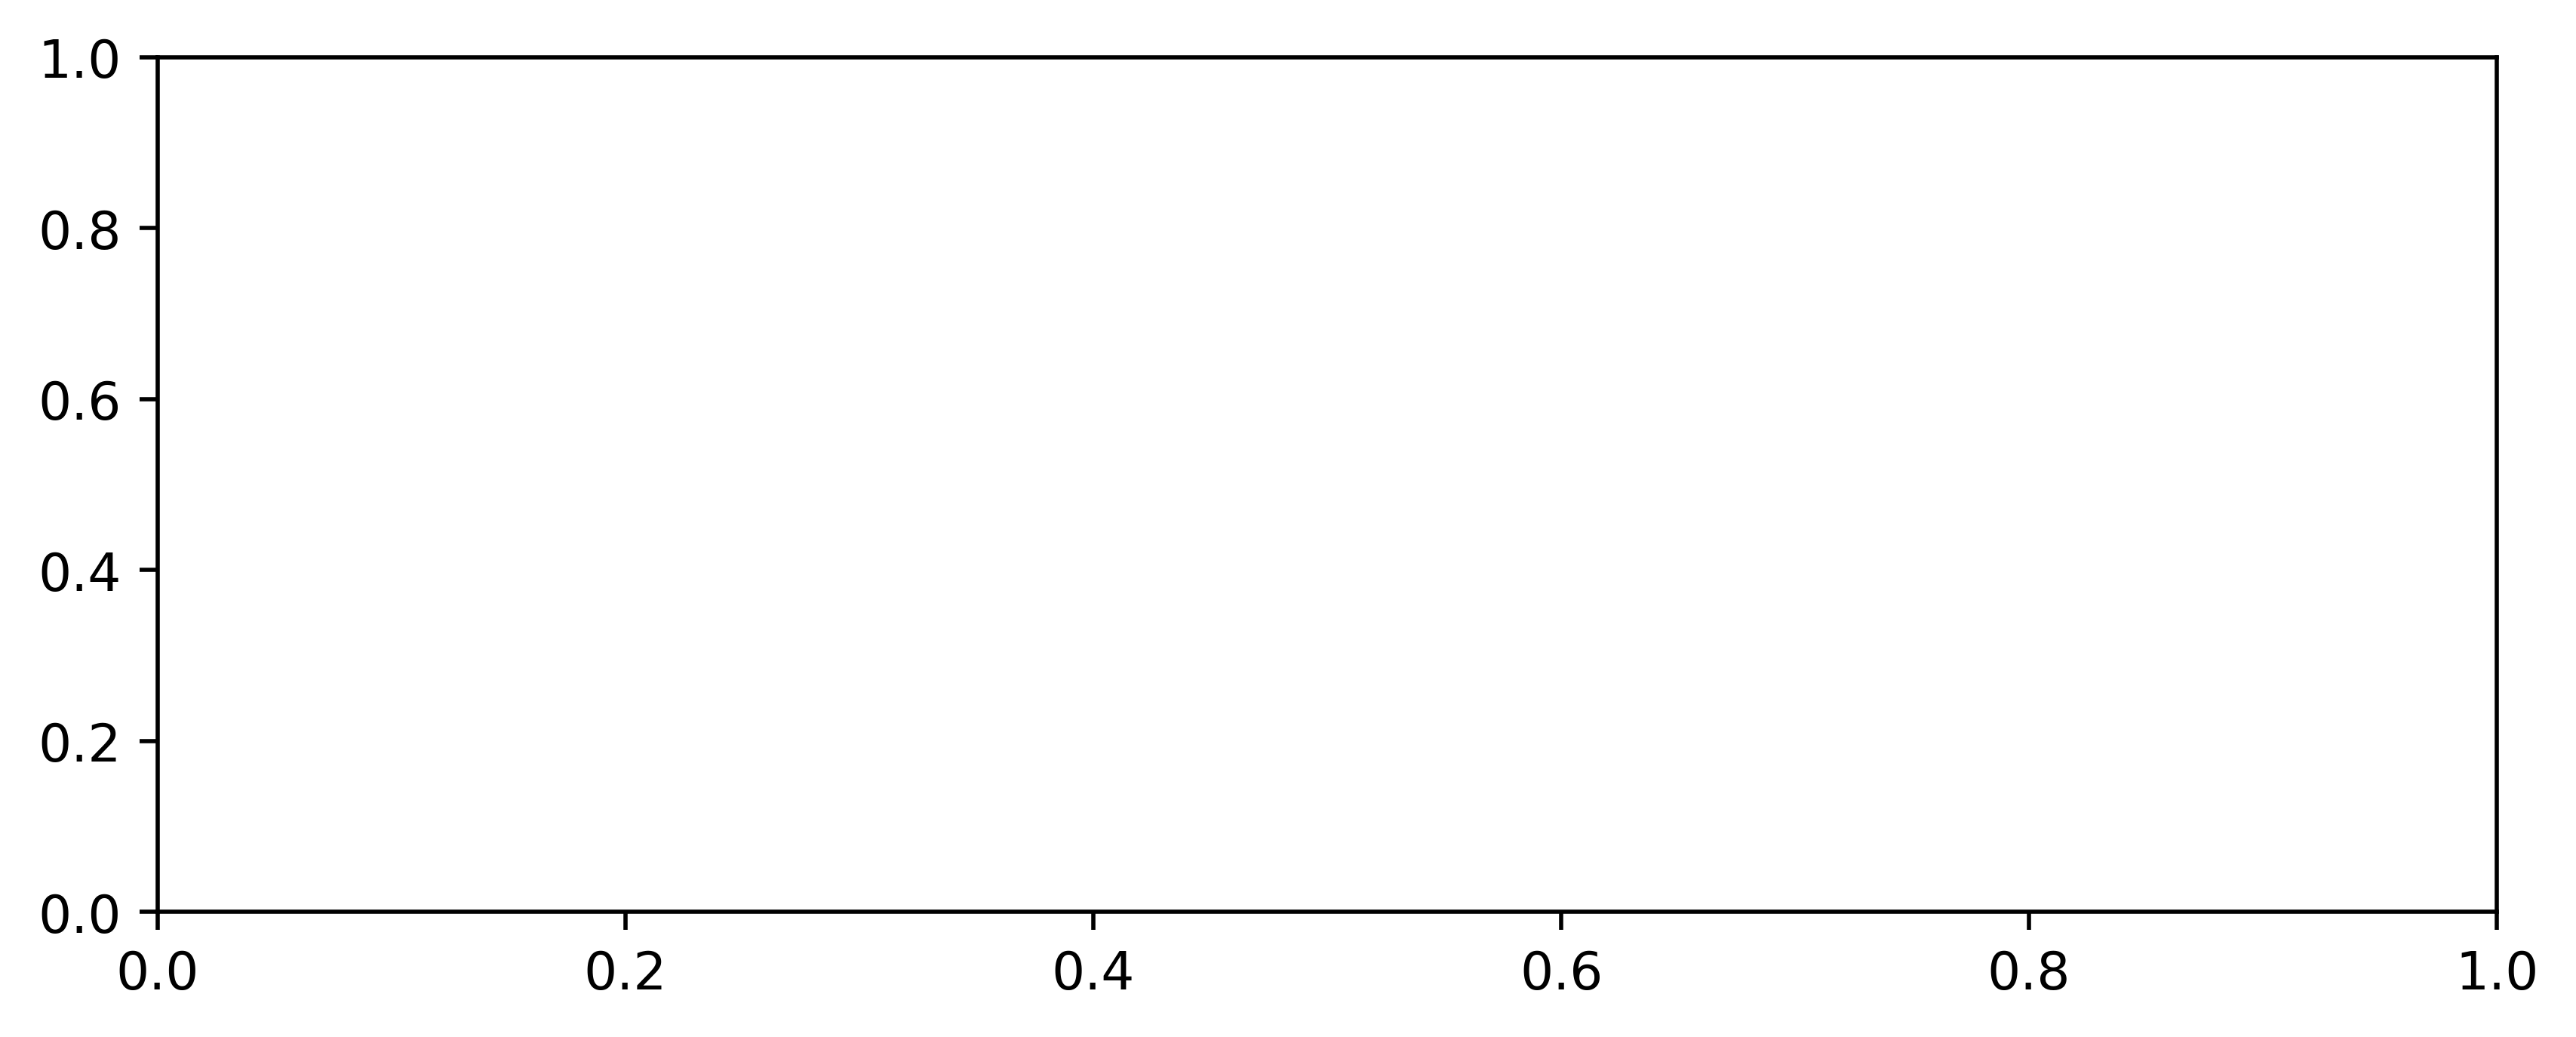

In [83]:
plt.plot(xsPos, svfsInv, label="Laplace inversion")
plt.plot(xsPos, svfsPoly, label="Pseudo-mixture")
plt.legend();

In [ ]:
svfsMed = np.median(np.array([svfsPoly, svfsInv]), axis=0)

In [ ]:
plt.plot(xsPos, svfsInv-svfsMed, label="Laplace inversion")
plt.plot(xsPos, svfsPoly-svfsMed, label="Pseudo-mixture")
plt.legend();

## Test 4: Pascal / Weibull.

In [87]:
N_alpha = 2
N_p = sym.QQ(1, 4)
U_β = sym.QQ(1, 2)
U_λ = sym.QQ(1, 2)

N = syms.NegativeBinomial('N', N_alpha, 1-N_p) 
U = syms.Weibull('U', U_λ, U_β)

ref_r = syms.E(U)
tilt = 1
tilt_frac = sym.QQ(1, 2)
ref_m_orig = tilt_frac / tilt
ref_m = ref_m_orig / (1 - ref_m_orig * tilt)
K=3

s = sym.symbols('s', real=True)
S_N_laplace, S_N_plus_laplace = S_N_lts(s, N, U, tilt)
S_N_plus_laplace

-1/16 + 1/(16*(1 - 3*sqrt(2)*sqrt(pi)*exp(1/(2*(s + 1)))*erfc(sqrt(2)/(2*sqrt(s + 1)))/(8*sqrt(s + 1)))**2)

In [91]:
%%time
# NOTE!! The "m_orig" is used here
qs = q_coefficients(S_N_plus_laplace, ref_r, ref_m_orig, K, fast=False)
qsFloat = [float(q.n()) for q in qs]
print(qsFloat)

[0.17945898064021254, 0.04288501799278778, 0.086816367551811, 0.017347369616847914]
Wall time: 15.9 s


In [89]:
[ref_r, ref_m_orig, ref_m]

[1, 1/2, 1]

In [92]:
ps = p_from_q(qs, ref_r, ref_m_orig, tilt, fast=False)
print(ps)

[ 0.41208592 -0.31482243  0.27819407  0.27755791]


In [93]:
pdfLT = sym.lambdify(s, S_N_laplace)
cdfLT = sym.lambdify(s, S_N_laplace/s)
svfLT = sym.lambdify(s, (1-S_N_laplace)/s)

pdfInv = np.vectorize(lambda x: transform_inversion(pdfLT, x))
cdfInv = np.vectorize(lambda x: transform_inversion(cdfLT, x))
svfInv = np.vectorize(lambda x: transform_inversion(svfLT, x))

LTStar = (1-S_N_laplace)/(s*syms.E(N)*syms.E(U))
cdfLTStar = sym.lambdify(s, LTStar / s)
svfLTStar = sym.lambdify(s, (1-LTStar) / s)

cdfStarInv = np.vectorize(lambda x: transform_inversion(cdfLTStar, x))
svfStarInv = np.vectorize(lambda x: transform_inversion(svfLTStar, x))

In [95]:
pdfInv(np.linspace(1,5,10))

array([0.12775501+25.05057505j, 0.11192264+21.93513114j,
       0.10054598+19.9530593j , 0.09151218+18.53385177j,
       0.08394364+17.4425743j , 0.077397  +16.56243323j,
       0.07161746+15.82794248j, 0.0664444 +15.19915638j,
       0.06176908+14.65013509j, 0.05751367+14.16319763j])

In [98]:
%%time 
rnd.seed(1)
R = int(1e6)

NDist = ss.nbinom(N_alpha, float(N_p))
UDist = ss.weibull_min(float(U_β), scale=float(U_λ))

rvs = rcompsum(R, NDist, UDist)

Wall time: 4.55 s


In [99]:
[syms.E(N), NDist.mean(), syms.E(N**2)-syms.E(N)**2, NDist.var()]

[6, 6.0, 24, 24.0]

In [100]:
[syms.E(U).n(), UDist.mean(), (syms.E(U**2)-syms.E(U)**2).n(), UDist.var()]

[1.00000000000000, 1.0, 5.00000000000000, 5.0]

In [101]:
posRVs = np.array([x for x in rvs if x > 0])
p_0 = (R - len(posRVs)) / R

In [102]:
xMax = np.max(rvs) / 2
xs = np.linspace(-2, xMax, 500)
xsPos = xs[xs > 0]

ref_r = float(ref_r)
ref_m = float(ref_m)

pdfsInv = np.array([pdfLT(x) for x in xsPos])
pdfsPoly = dcompsum(xsPos, ps, ref_r, ref_m)

qsEmp = (1-p_0) * q_coefficients_empirically(posRVs, K, ref_r, ref_m)

pdfsLag = laguerre_expansion(qsFloat, xsPos, ref_r, ref_m)
pdfsLagEmp = laguerre_expansion(qsEmp, xsPos, ref_r, ref_m)

In [103]:
if USE_KDE:
    pdfsKDEAll = kde.ssvkernel(posRVs, xs, nbs=1)[0]
    probNeg = np.sum(pdfsKDEAll[xs <= 0] * (xs[1] - xs[0]))
    pdfsKDE = pdfsKDEAll[xs > 0] * (1 - p_0) / (1 - probNeg)
    print(f"probNeg={probNeg} scaling={(1 - p_0) / (1 - probNeg)}")

probNeg=0.07302820982669288 scaling=1.0115205337852797


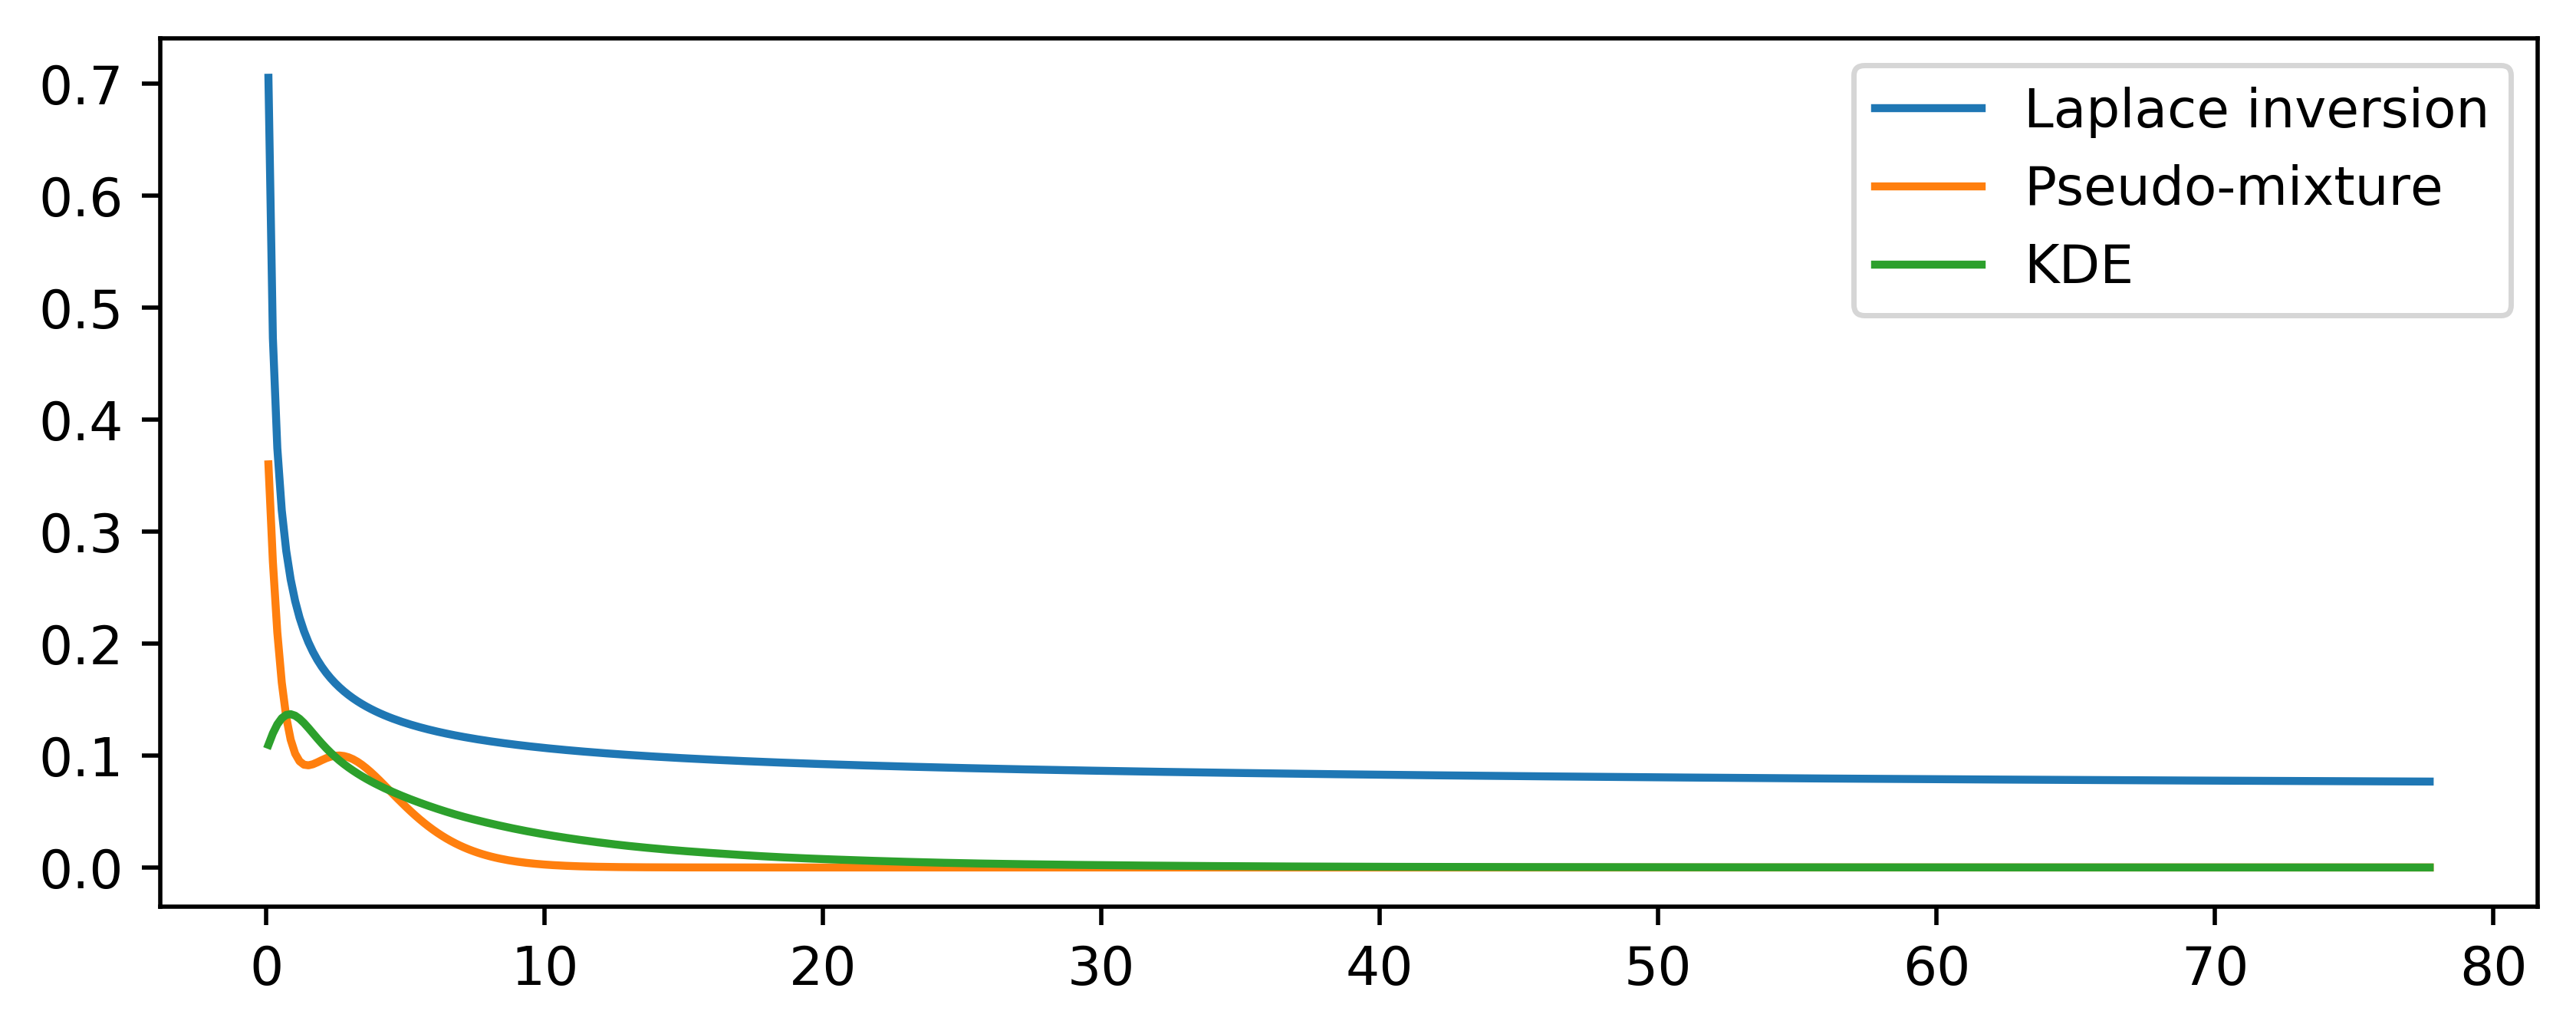

In [104]:
plt.plot(xsPos, pdfsInv, label="Laplace inversion")
plt.plot(xsPos, pdfsPoly, label="Pseudo-mixture")
#plt.plot(xsPos, pdfsLag, label="Laguerre")
#plt.plot(xsPos, pdfsLagEmp, label="Laguerre Emp.")
if USE_KDE:
    plt.plot(xsPos, pdfsKDE, label="KDE")
#plt.gca().set_xlim((0, xmax))
plt.legend();

In [105]:
pdfsMed = np.median(np.array([pdfsInv, pdfsPoly]), axis=0)

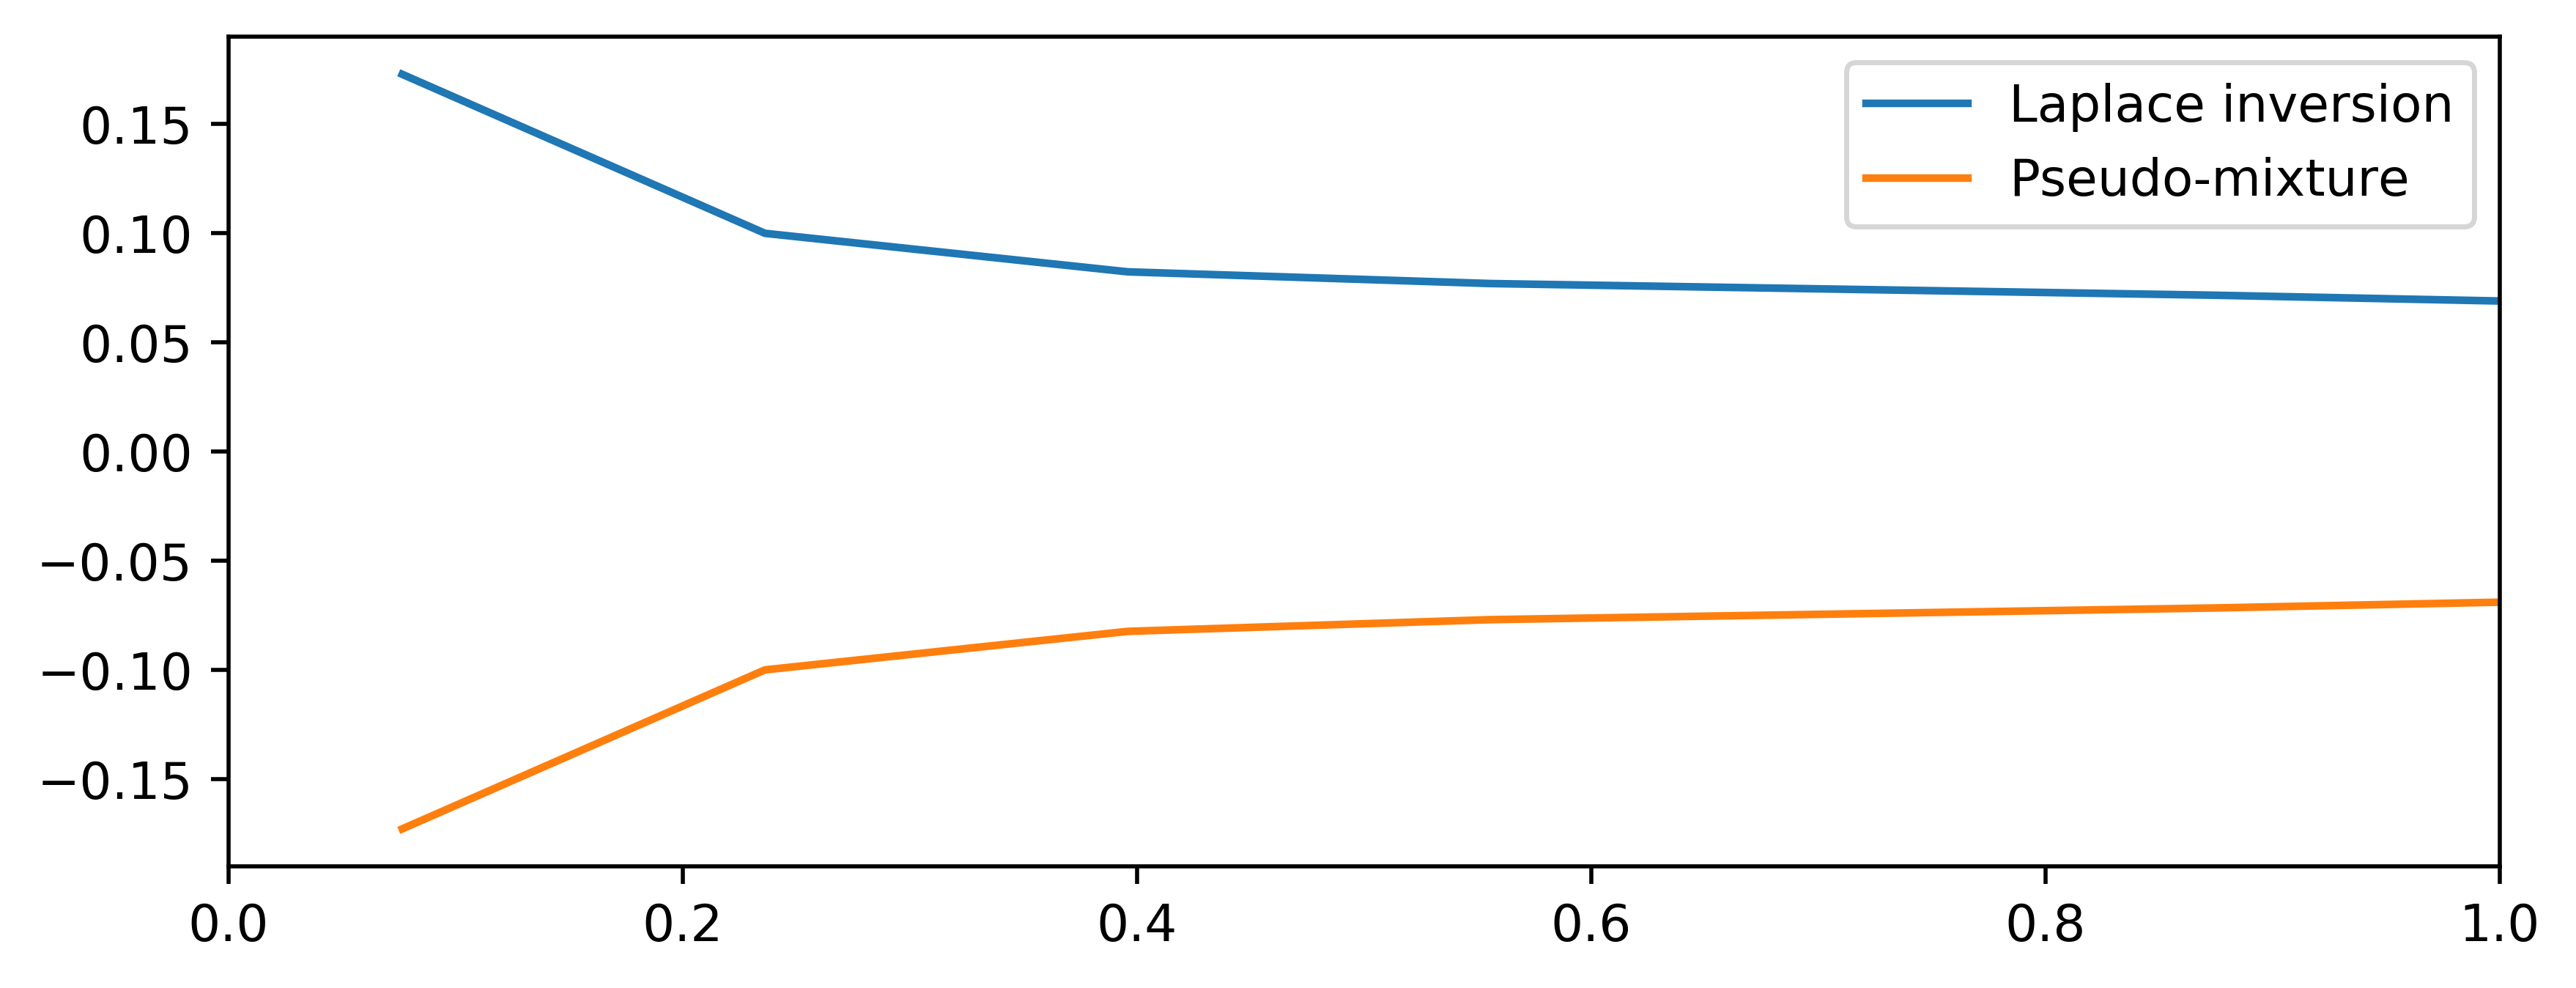

In [106]:
plt.plot(xsPos, pdfsInv-pdfsMed, label="Laplace inversion") 
#plt.plot(xsPos, pdfsLag-pdfsMed, label="Laguerre")
#plt.plot(xsPos, pdfsLagEmp-pdfsMed, label="Laguerre Emp")
plt.plot(xsPos, pdfsPoly-pdfsMed, label="Pseudo-mixture")
# if USE_KDE:
#     plt.plot(xsPos, pdfsKDE-pdfsMed, label="KDE")
plt.gca().set_xlim((0, 1))
plt.legend();

In [107]:
svfsPoly = 1 - pcompsum(xsPos, ps, ref_r, ref_m)
svfsInv = svfInv(xsPos)

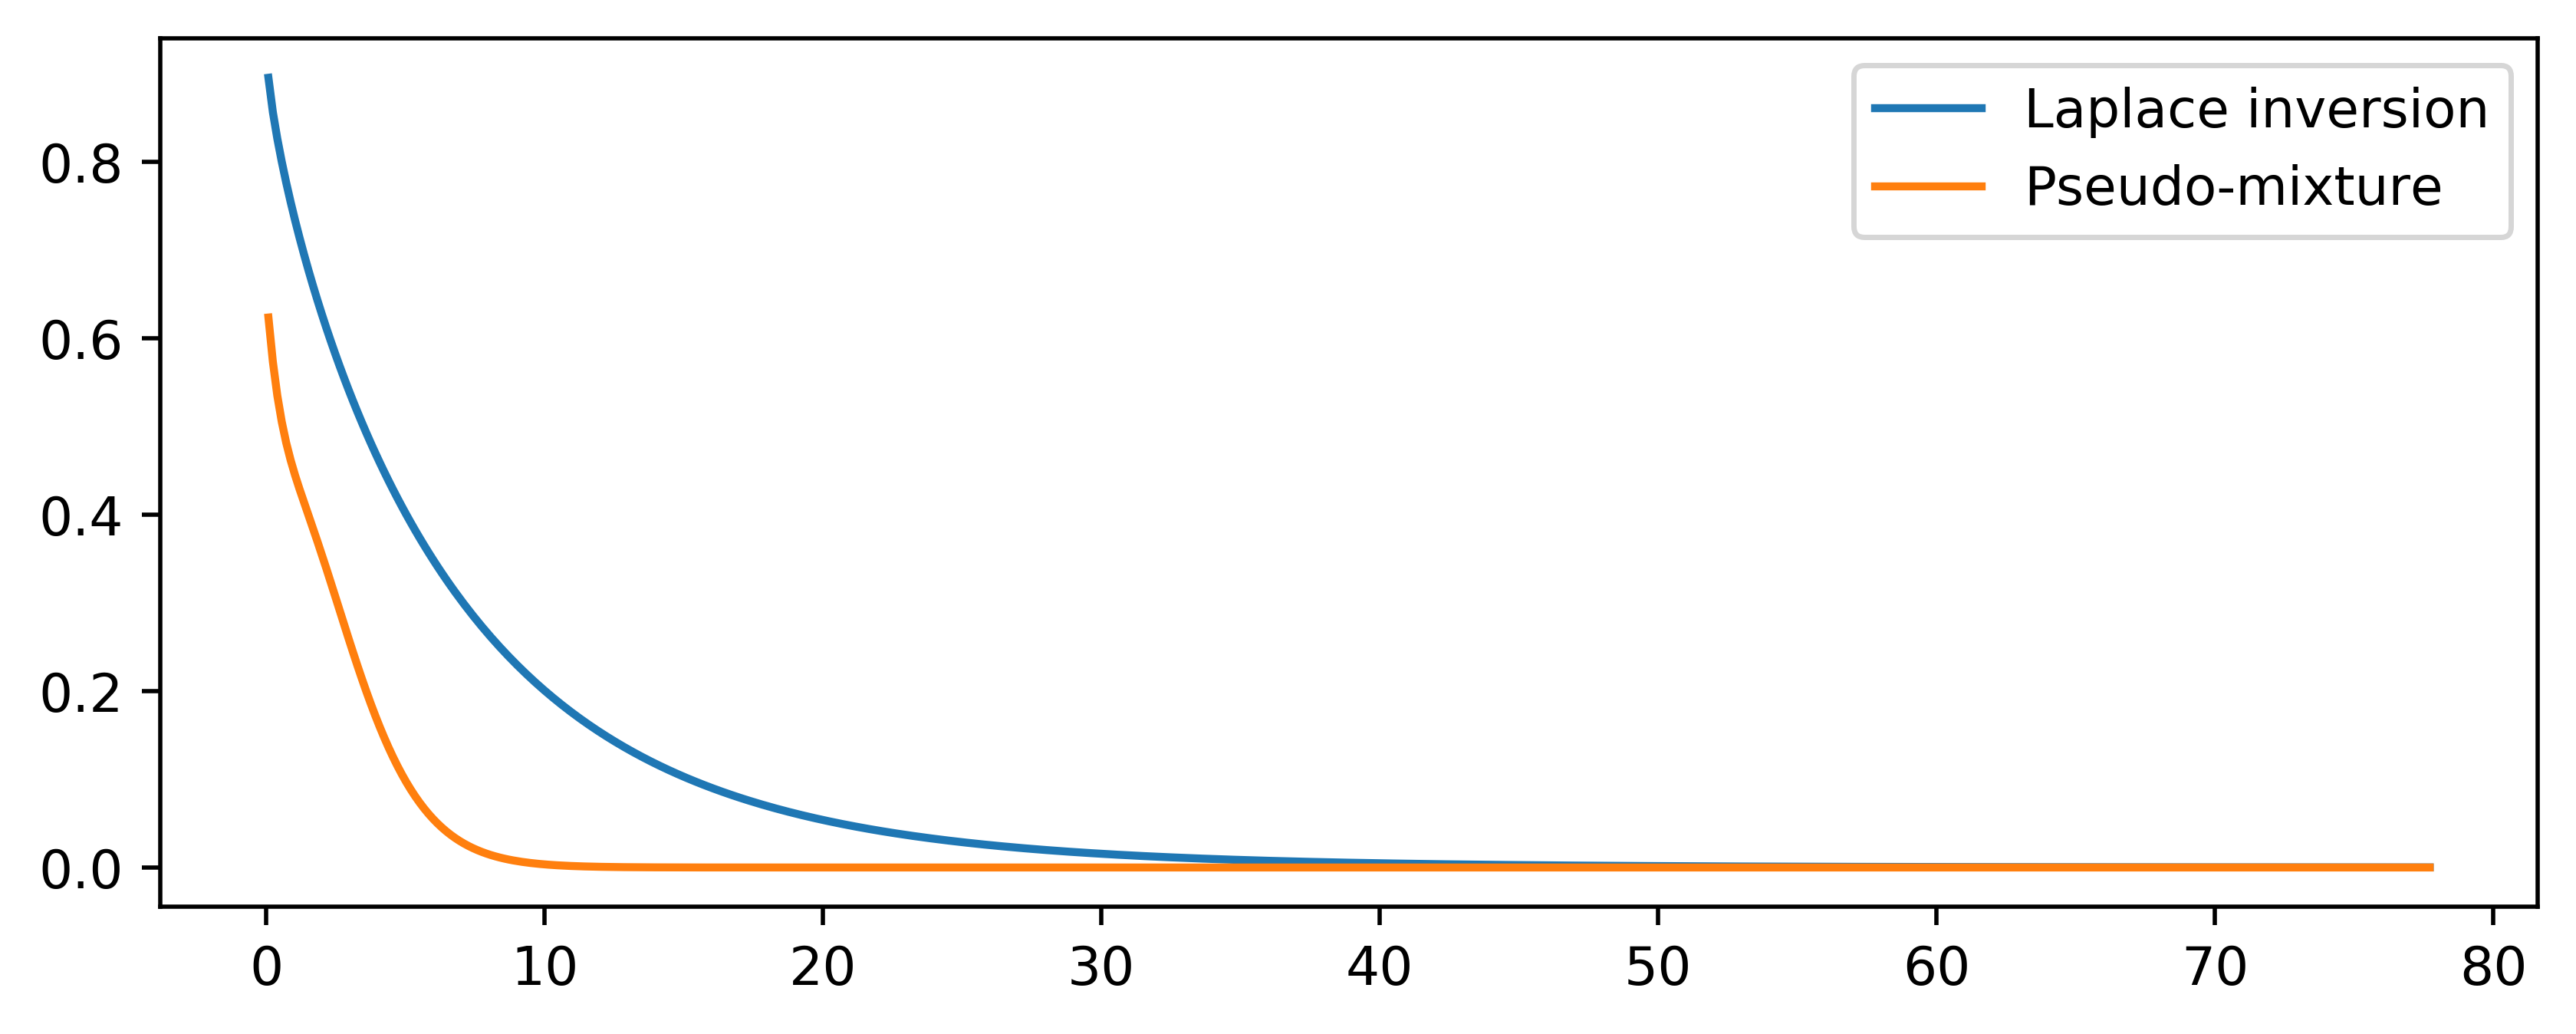

In [108]:
plt.plot(xsPos, svfsInv, label="Laplace inversion")
plt.plot(xsPos, svfsPoly, label="Pseudo-mixture")
plt.legend();

In [109]:
svfsMed = np.median(np.array([svfsPoly, svfsInv]), axis=0)

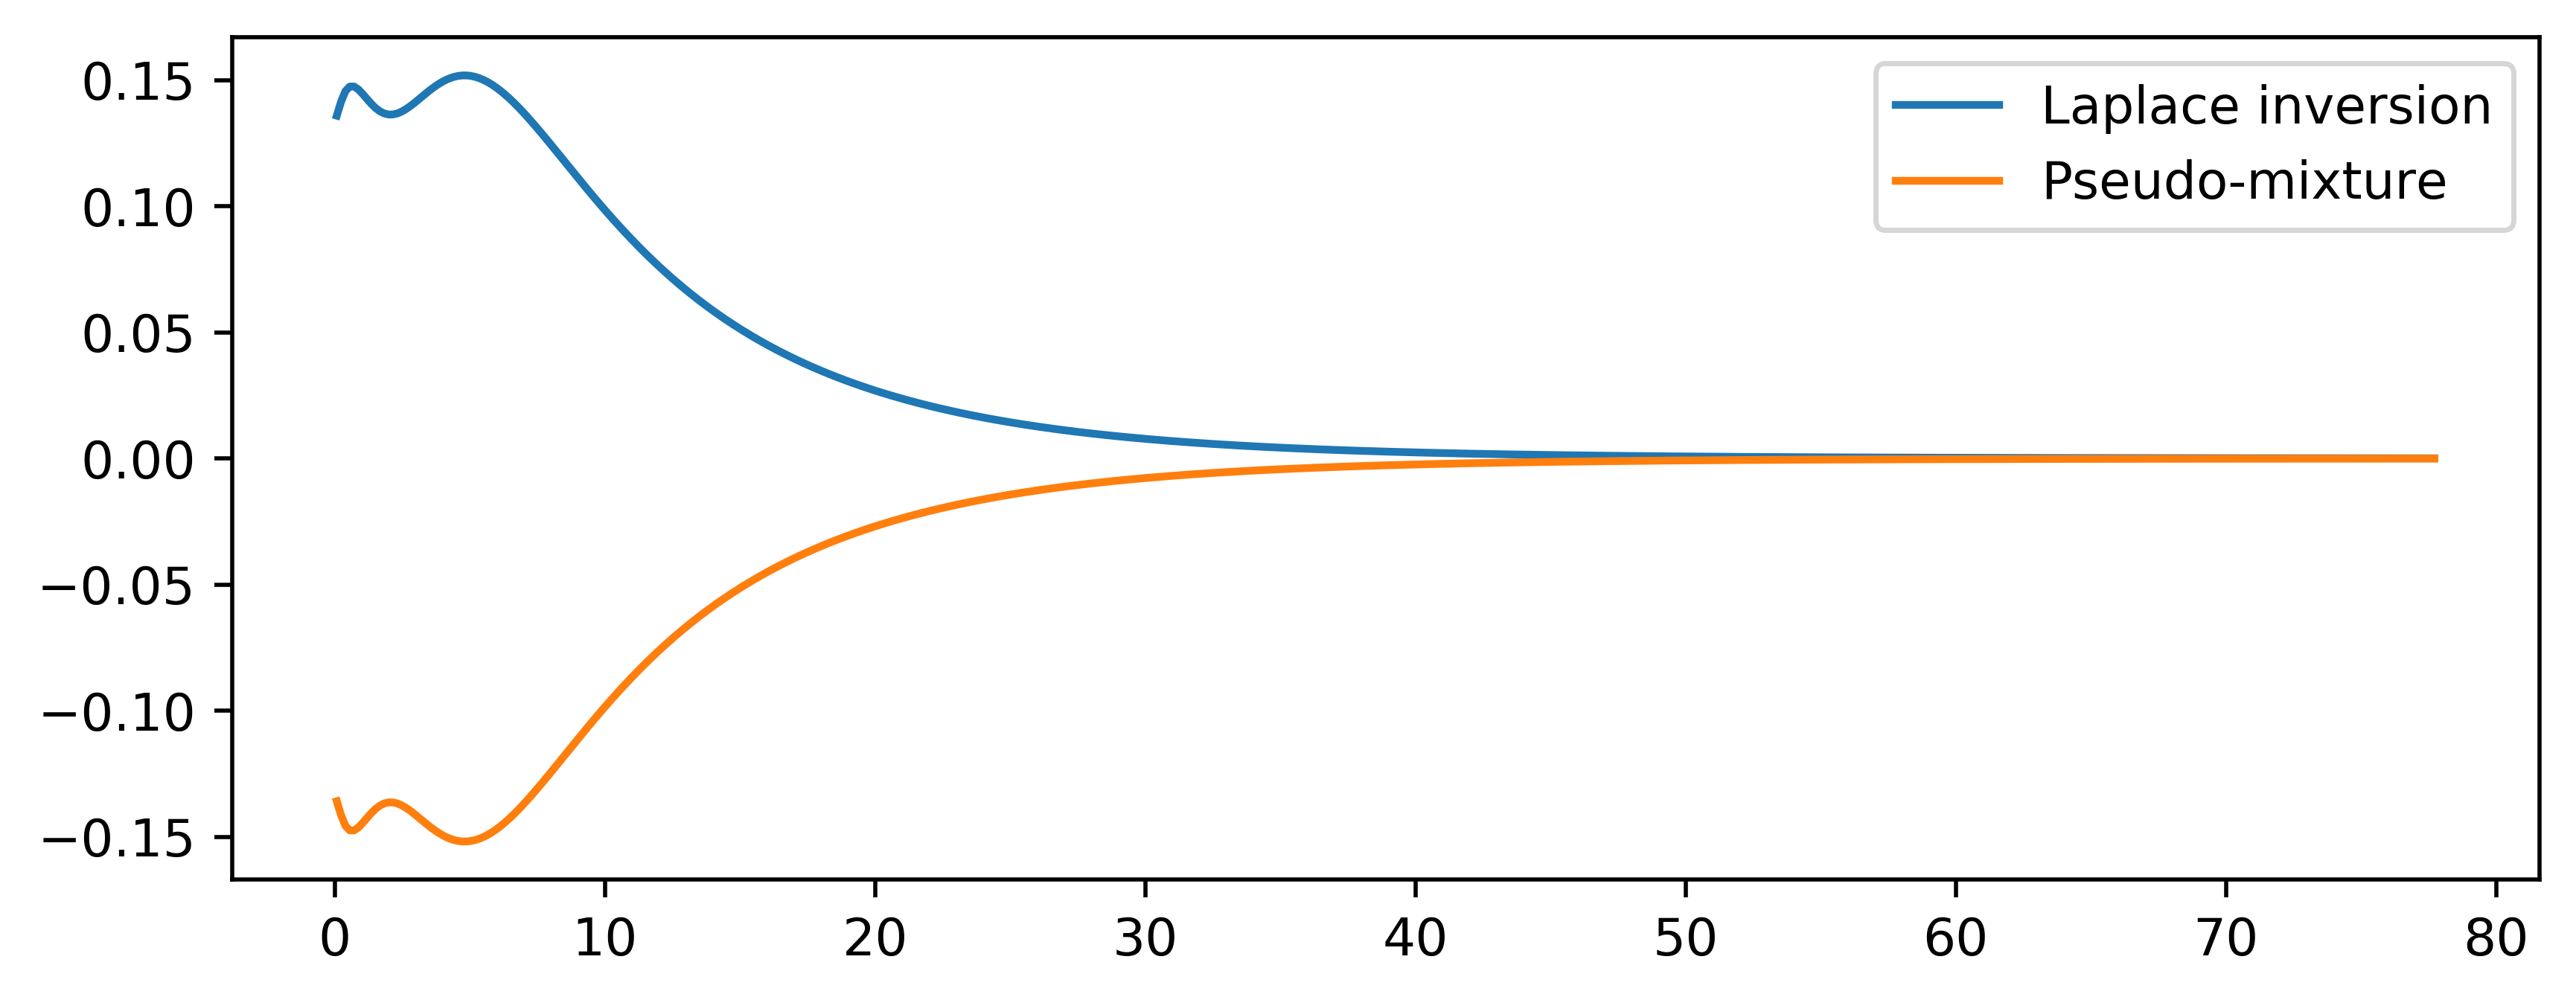

In [110]:
plt.plot(xsPos, svfsInv-svfsMed, label="Laplace inversion")
plt.plot(xsPos, svfsPoly-svfsMed, label="Pseudo-mixture")
plt.legend();